# Hotel Customer Segmentation - Clustering and Pre-processing

## Objective
### Prepairing data for clustering and classification predictions. 

### Modeling for business KPIs identified:
1. Increased bookings and subsequently revenues.
2. Reduced cancelations and noshows

* By targeting hotel accomodations, offerings and makerting, you can trigger more impactful communications and promotions. There should be a positive impact in bookings and revenue. This can be enhanced with better customer segmenation, user personas and user case stories.
* By labeling a customer record in the booking system based on value, management is better able to make decisions about resources and priorites.
* By predicting if a customer is at risk of attrition, commnications and promotion triggers as well as managment action could potential reduce the rate of both. 

## Data

A clean dataframe including normalized RFM calculation from
a real-world customer dataset with 31 variables describes
83,590 instances (customers) from a hotel in Lisbon, Portugal.
Instances include; customer personal, behavioral,
demographic, and geographical information for 3 full years.
The dataset can be found on Kaggle [here].(https://www.kaggle.com/datasets/nantonio/a-hotels-customers-dataset)

Kaggle dataset origin, domain assumptions and data collection information: 

Nuno Antonio, Ana de Almeida, Luis Nunes. A hotel's customer's personal, behavioral, demographic, and geographic dataset from Lisbon, Portugal (2015-2018). Data in Brief 33(2020)106583, 24(November), 2020. URL: https://www.sciencedirect.com/journal/data-in-brief.

## Data Assumptions

Data is aggreated and querried from company SQL database and provided in the flatfile.
* Some hotels have a policy of creating a profile for each guest companion(adult or children) only in particular cases and with authorization at times. 
* Typically a customer profile is created by one of three things:
    - customer's first checked-out at the hotel
    - customer's first cancelation
    - customer's first no-show
* Sometimes there are more than one profile for the same customer
* Only after the customer's first stay can hotels confirm the guest's personal details, such as nationality.

## Process

1. [Feature engineering, transformation and scaling](#feature-engineering) 
2. [Cluster on all features](#cluster-on-all-features)
3. [Data split for training and testing](#split-the-data-into-train-and-test-sets)
4. [Baseline model](#baseline-dummy-classifier) 

## Questions

1. Do categorical variables need to be encoded? 
2. Does the data need scaling? 
3. What is the optimal number of clusters? Elbow method?
4. Can we model an attrition risk classification or a CLV regression with the same clustering dataset?
5. What baseline models will we use for attrition prediction?

## Considerations

1. Scaling and and log transformations were performed on the RFM data. 
2. Few pairwise correlations observed in heatmap. 
2. High imbalence in the a value feature of Total Revenue. 
3. High imbalence in categorical features related to sales and market segments. 
4. The hotel_customer_rfm dataframe refers to the the quantile derived  "RFM_Segments"
5. The hotel_customer_rfm_cluster dataframe refers to the KMeans derived "RFM_Clusters"

## Import Data

Import previous EDA notebook progress. 

In [1]:
from IPython.utils import io
with io.capture_output() as captured:
    %run 2_EDA.ipynb

In [2]:
hotel_customer_rfm.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   4         FRA  60.0               1095               93           240.0   
3   6         JPN  54.0               1095               58           230.0   
4   8         FRA  32.0               1095               38           535.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2          60.0                 0                 0                  1  ...   
3          24.0                 0                 0                  1  ...   
4          94.0                 0                 0                  1  ...   

   SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom  \
0               0                   0                     0            0   
1               0                   0                     0            0   
2               0                   0                     0            0   
3               0                   0                     0            0   
4               0                   0                     0            0   

  Country TotalRevenue  Attrition  Recency  Frequency  Monetary  
0     PRT        476.3      False      151          5     476.3  
1     PRT        333.0       True     1100          5     333.0  
2     FRA        300.0       True     1100          5     300.0  
3   Other        254.0       True     1097          2     254.0  
4     FRA        629.0       True     1100          5     629.0  

[5 rows x 35 columns]

In [3]:
hotel_customer_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 63669
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    63670 non-null  int64  
 1   Nationality           63670 non-null  object 
 2   Age                   63670 non-null  float64
 3   DaysSinceCreation     63670 non-null  int64  
 4   AverageLeadTime       63670 non-null  int64  
 5   LodgingRevenue        63670 non-null  float64
 6   OtherRevenue          63670 non-null  float64
 7   BookingsCanceled      63670 non-null  int64  
 8   BookingsNoShowed      63670 non-null  int64  
 9   BookingsCheckedIn     63670 non-null  int64  
 10  PersonsNights         63670 non-null  int64  
 11  RoomNights            63670 non-null  int64  
 12  DaysSinceLastStay     63670 non-null  int64  
 13  DaysSinceFirstStay    63670 non-null  int64  
 14  DistributionChannel   63670 non-null  object 
 15  MarketSegment      

## Import New Libraries

In [4]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from collections import Counter 
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve



## Feature Engineering

How many RFM cusotomer categories serve our business uses and KPIs?

Here are some important segments to understand and viusalize for our goals:
1. High, medium and low value
2. At risk of churn
3. Likely to re-book
 *  What are the behaviors and demographics of these segments?

### RFM Scoring - Overall Cusotmer Value Based on Recencey, Frequency and Monetary Spend

#### Low, Medium & High Value Customers. *Not based on lifetime value prediction. 

Let's first segment according to the customer RFM values by assigning an overal score column to the customer. First we will make a score for each Recency, Frequency and Monetary based on what quantiles the customer value sits in, within the distribution of scores.  We can label these categories for better interpretability as well. We can ues these RFM scores to compare to our clustering model later on. We are not using the normalized values of these categories, but do have that information ready in table hotel_customer_rfm_norm if we need to use it. I believe we can do this once we start clustering. 

#### Create label columns for customers of thier monetatry and frequency scores
##### Recency decreases because a lower value is better in this case.

In [12]:
#r_labels = range(3,0,-1); 

#r_groups = pd.qcut(hotel_customer_rfm['Recency'], q=3, labels=r_labels)

f_labels = range(1,4)
f_groups = pd.qcut(hotel_customer_rfm['Frequency'], q=3, labels=f_labels)

#### Create label columns for customers of their monetary scores

In [13]:
m_labels = range(1,4)

m_groups = pd.qcut(hotel_customer_rfm['Monetary'], q=3, labels=m_labels)

hotel_customer_rfm = hotel_customer_rfm.assign(M=m_groups.values)

In [14]:
hotel_customer_rfm = hotel_customer_rfm.assign(M=m_groups.values, F=f_groups.values)

#### Calculate RFM Score

In [15]:
hotel_customer_rfm['FM_Score'] = hotel_customer_rfm[['F', 'M']].sum(axis=1)
print(hotel_customer_rfm['FM_Score'].head())

0    5.0
1    5.0
2    5.0
3    2.0
4    6.0
Name: FM_Score, dtype: float64


How many different scores are there?

In [16]:
hotel_customer_rfm.FM_Score.nunique()

5

In [17]:
hotel_customer_rfm.FM_Score.unique()

array([5., 2., 6., 3., 4.])

What is the average monetary value of each RFM score segment?

In [161]:
hotel_customer_rfm['Monetary'].groupby(hotel_customer_rfm['FM_Score']).mean()

FM_Score
2.0    167.146892
3.0    312.373522
4.0    437.934693
5.0    578.459148
6.0    929.943295
Name: Monetary, dtype: float64

What is the distribution of FM scores in our data?

<AxesSubplot:>

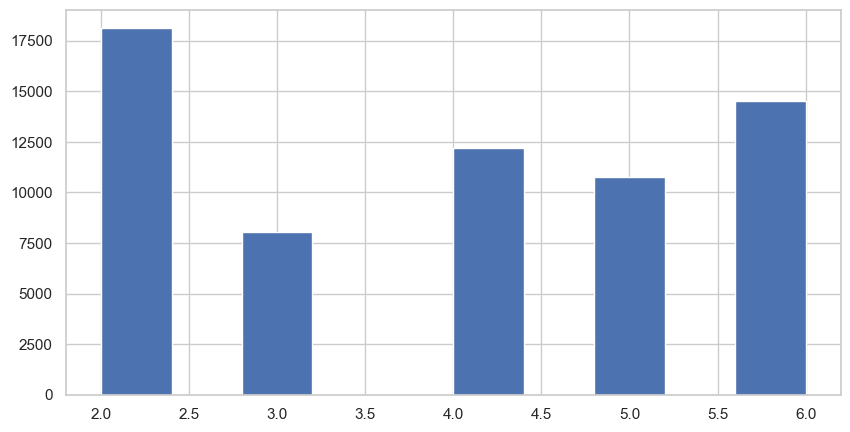

In [19]:
hotel_customer_rfm.FM_Score.hist()

### Identifying FM Segments

Build segmentation based on RFM Scores and assing it to each cusomer. Our top earning score is 9. If we evenly divide the levels, into Low, Medium and High is should be 1-3 Low, 4-6 Medium & 7-10 Top respectively:

* 0 - 2: Low Value
* 3 - 5: Mid Value
* 6 - 8: Top Value 

In [20]:
#Segment level function

def rfm_level(hotel_customer_rfm):
    if hotel_customer_rfm['FM_Score'] >= 6:
        return 'Top'
    elif ((hotel_customer_rfm['FM_Score'] >= 3) and (hotel_customer_rfm['FM_Score'] < 5)):
        return 'Middle'
    else:
        return 'Low'

#Create FM_Level feature for value segment label
hotel_customer_rfm['FM_Segment'] = hotel_customer_rfm.apply(rfm_level, axis=1)


What are the average values for each FM Segment level and the segment size?

In [22]:
FM_Segment_agg = hotel_customer_rfm.groupby('FM_Segment').agg({'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)
print(FM_Segment_agg)

           Frequency Monetary       
                mean     mean  count
FM_Segment                          
Low              2.3    320.3  28876
Middle           2.6    388.0  20259
Top              5.4    929.9  14535


In [23]:
fig1 = px.scatter(hotel_customer_rfm, x="DaysSinceLastStay", y="Monetary", color="FM_Segment",
                 size="Frequency")

fig1.update_layout(title="Customer Cluster Scatterplot")
fig1.show()

Coorelation heatmap with RFM features

<AxesSubplot:>

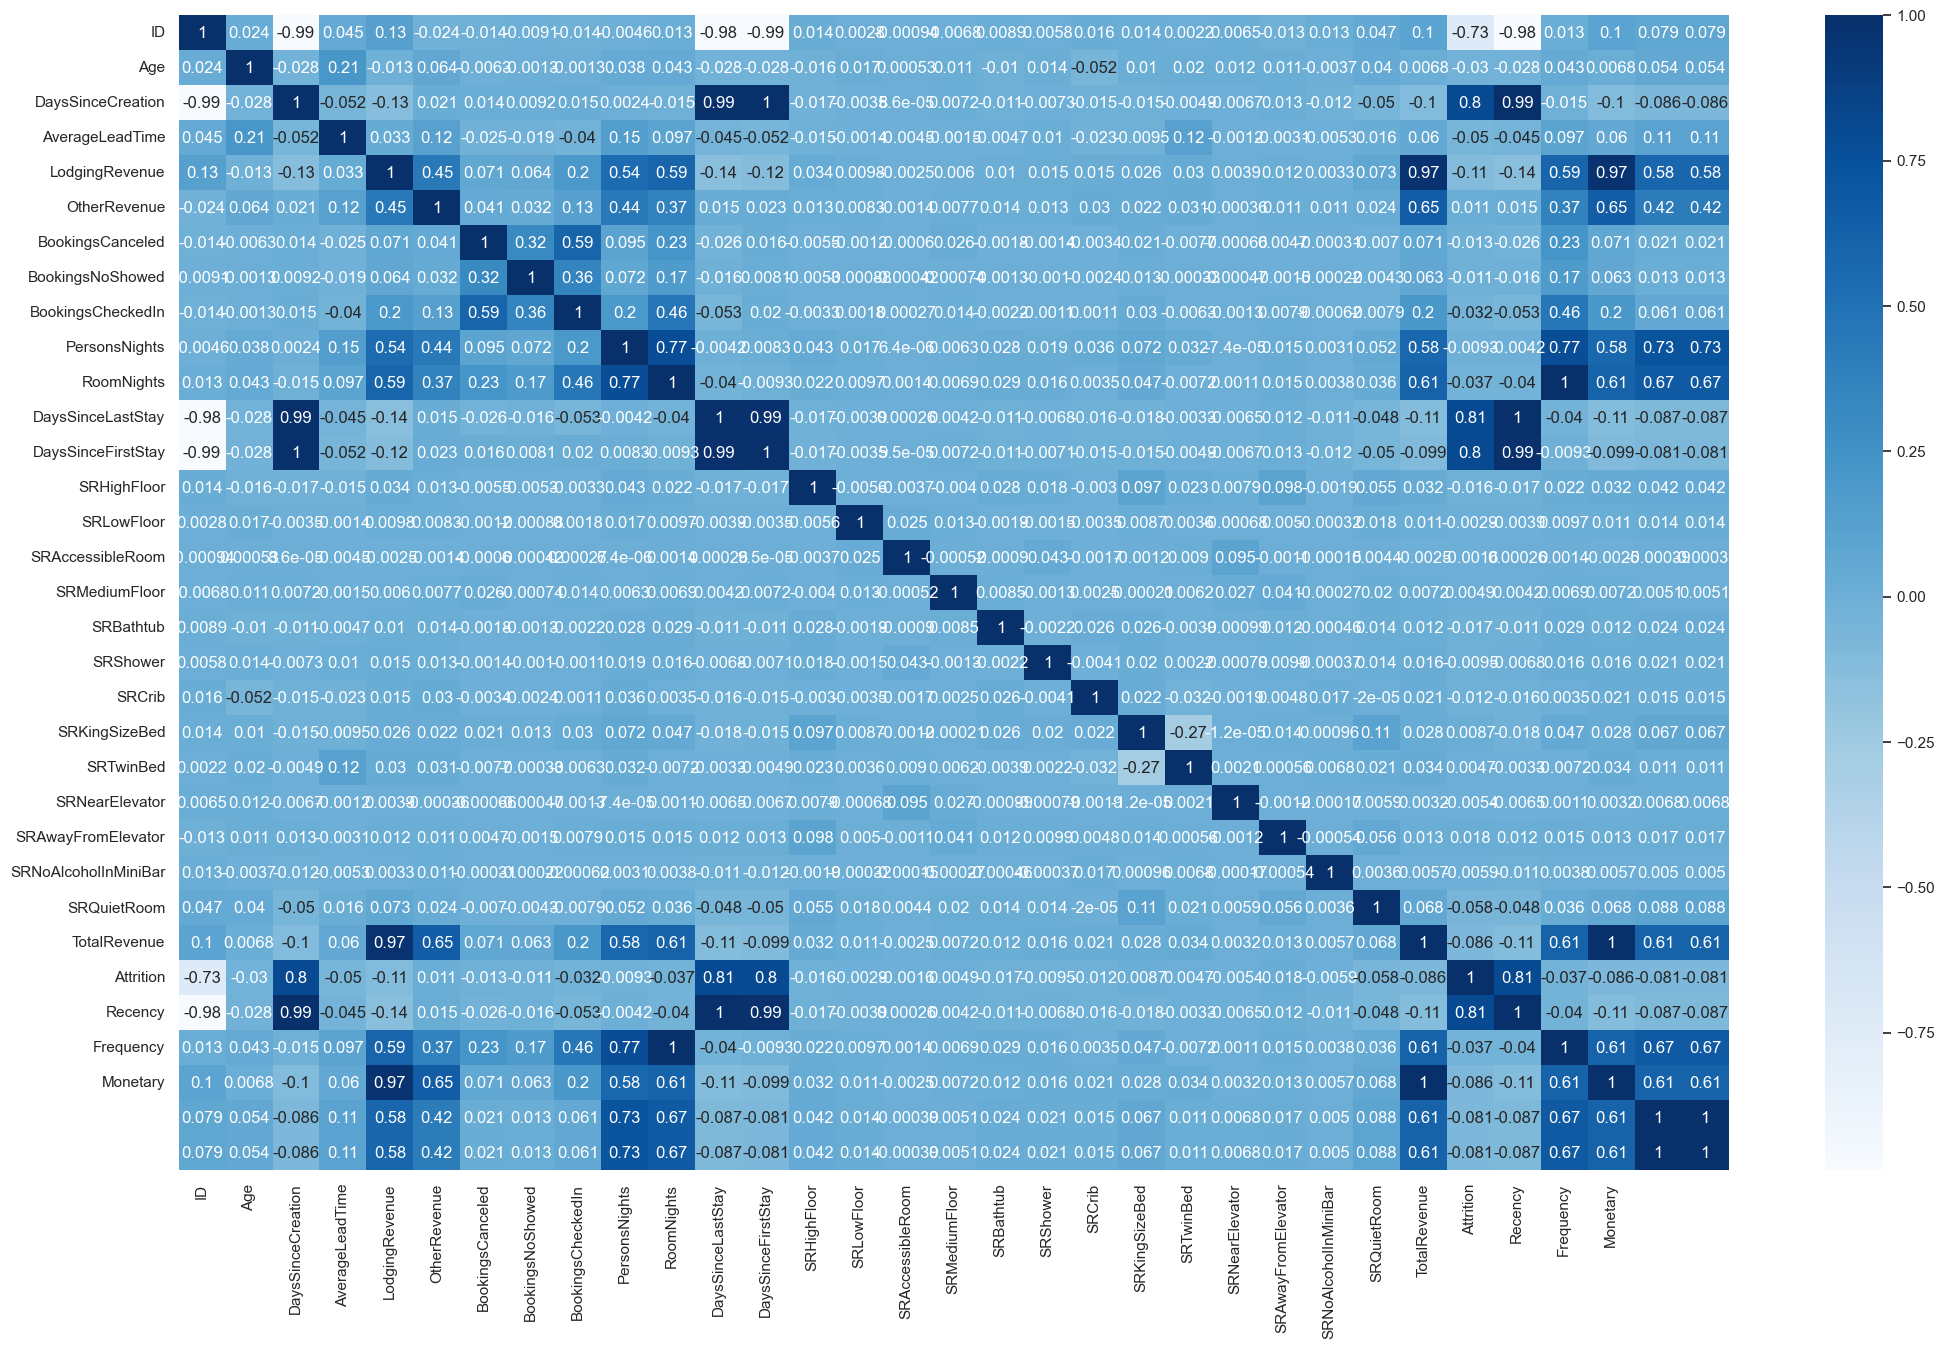

In [24]:
fig, ax = plt.subplots(figsize=(25, 15))

fm_corr = hotel_customer_rfm.corr()
sns.heatmap(fm_corr, cmap="Blues", annot= True,
        xticklabels=rfm_corr.columns,
        yticklabels=rfm_corr.columns)

In [25]:
hotel_customer_rfm.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   4         FRA  60.0               1095               93           240.0   
3   6         JPN  54.0               1095               58           230.0   
4   8         FRA  32.0               1095               38           535.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2          60.0                 0                 0                  1  ...   
3          24.0                 0                 0                  1  ...   
4          94.0                 0                 0                  1  ...   

   TotalRevenue  Attrition  Recency  Frequency Monetary  M  F  RFM_Score  \
0         476.3      False      151          5    476.3  2  3        5.0   
1         333.0       True     1100          5    333.0  2  3        5.0   
2         300.0       True     1100          5    300.0  2  3        5.0   
3         254.0       True     1097          2    254.0  1  1        2.0   
4         629.0       True     1100          5    629.0  3  3        6.0   

   FM_Score  FM_Segment  
0       5.0         Low  
1       5.0         Low  
2       5.0         Low  
3       2.0         Low  
4       6.0         Top  

[5 rows x 40 columns]

In [26]:
hotel_customer_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 63669
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID                    63670 non-null  int64   
 1   Nationality           63670 non-null  object  
 2   Age                   63670 non-null  float64 
 3   DaysSinceCreation     63670 non-null  int64   
 4   AverageLeadTime       63670 non-null  int64   
 5   LodgingRevenue        63670 non-null  float64 
 6   OtherRevenue          63670 non-null  float64 
 7   BookingsCanceled      63670 non-null  int64   
 8   BookingsNoShowed      63670 non-null  int64   
 9   BookingsCheckedIn     63670 non-null  int64   
 10  PersonsNights         63670 non-null  int64   
 11  RoomNights            63670 non-null  int64   
 12  DaysSinceLastStay     63670 non-null  int64   
 13  DaysSinceFirstStay    63670 non-null  int64   
 14  DistributionChannel   63670 non-null  object  
 15  Ma

Check for Top segment miscategorization 

In [27]:
zero_revenue_segments = hotel_customer_rfm.loc[hotel_customer_rfm['Monetary'] == 0]
len(zero_revenue_segments)

285

In [29]:
mis_top_customers = zero_revenue_segments.FM_Segment.value_counts()
mis_top_customers

Low       231
Middle     54
Name: FM_Segment, dtype: int64

Not a significatnt mis categorizatio of zero revenue customres placed into the Top segment. 

Check for Low segment miscategorization

In [30]:
high_revenue_segment = hotel_customer_rfm.loc[hotel_customer_rfm['Monetary'] >= 1000]

In [31]:
mis_low_customers = high_revenue_segment.FM_Segment.value_counts()
mis_low_customers

Top       3669
Low       1069
Middle     293
Name: FM_Segment, dtype: int64

No misclassification alarm, this segmenting makes a lot of sense. 

### RFM Clustering with  with KMeans

Use rfm_normalized dataframe which is scaled, in order to meet the data criteria for the KMeans algorithm.

In [32]:
hotel_customer_rfm_norm.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   4         FRA  60.0               1095               93           240.0   
3   6         JPN  54.0               1095               58           230.0   
4   8         FRA  32.0               1095               38           535.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2          60.0                 0                 0                  1  ...   
3          24.0                 0                 0                  1  ...   
4          94.0                 0                 0                  1  ...   

   SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom  \
0               0                   0                     0            0   
1               0                   0                     0            0   
2               0                   0                     0            0   
3               0                   0                     0            0   
4               0                   0                     0            0   

  Country TotalRevenue  Attrition   Recency  Frequency  Monetary  
0     PRT        476.3      False -1.054639   1.110325  0.340523  
1     PRT        333.0       True  1.109694   1.110325 -0.085840  
2     FRA        300.0       True  1.109694   1.110325 -0.210161  
3   Other        254.0       True  1.106717  -0.478311 -0.408446  
4     FRA        629.0       True  1.109694   1.110325  0.671797  

[5 rows x 35 columns]

 Kmeans clustering is a fast and simple method of segmenting if the data meet have similar variable averages and standard deviations. The RFM variables we'll use to cluster have been transformed and normalized using the standard scaler in the previous EDA step. 

Data check for above criteria

In [33]:
# Get the key statistics of the dataset
print(hotel_customer_rfm_norm[['Frequency', 'Monetary']].describe())

          Frequency      Monetary
count  6.367000e+04  6.367000e+04
mean   3.838962e-16 -7.874336e-16
std    1.000008e+00  1.000008e+00
min   -1.680067e+00 -7.004922e+00
25%   -4.783107e-01 -5.048486e-01
50%    2.246717e-01  6.214277e-02
75%    7.234457e-01  5.720957e-01
max    7.370819e+00  4.978085e+00


### Inital KMeans model with 3 clusters

In [36]:
Kmeans = KMeans(n_clusters=3, random_state=42, max_iter=50)

Kmeans.fit(rfm_normalized)

cluster_labels = Kmeans.labels_

#Create a dataframe with new cluster labels
fm_kmeans3 = rfm.assign(FM_Cluster=cluster_labels)

#Group data by cluster and calculate average RFM values and segment size per cluster
fm_kmeans3_agg = fm_kmeans3.groupby(['FM_Cluster']).agg({'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

print(fm_kmeans3_agg)

           Frequency Monetary       
                mean     mean  count
FM_Cluster                          
0                3.1    419.6  24339
1                3.1    554.2  15979
2                3.1    495.0  23352


In [38]:
fm_kmeans3.FM_Cluster.nunique()

3

In [39]:
fm_kmeans3.sort_values(by='FM_Cluster')

ID  Recency  Frequency  Monetary  FM_Cluster
0          1      151          5    476.30           0
17294  17295      799          5    465.25           0
17293  17294      798          4    454.00           0
17292  17293      805         11   2096.50           0
17291  17292      798          4    486.00           0
...      ...      ...        ...       ...         ...
40971  40972      415          4    533.95           2
40972  40973      414          3    222.00           2
40973  40974      414          3    205.50           2
40975  40976      414          3    462.52           2
32896  32897      531          3    407.30           2

[63670 rows x 5 columns]

In [40]:
fm_kmeans3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 83588
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          63670 non-null  int64  
 1   Recency     63670 non-null  int64  
 2   Frequency   63670 non-null  int64  
 3   Monetary    63670 non-null  float64
 4   FM_Cluster  63670 non-null  int32  
dtypes: float64(1), int32(1), int64(3)
memory usage: 2.7 MB


Give the labels meaning. 

In [41]:
current_labels = [0,1,2]
desired_labels = ['Low', 'Mid', 'Top']
map_dict = dict(zip(current_labels, desired_labels))
map_dict

{0: 'Low', 1: 'Mid', 2: 'Top'}

In [42]:
fm_kmeans3['FM_Cluster'] = fm_kmeans3['FM_Cluster'].map(map_dict)

In [43]:
hotel_customer_rfm_clustered = pd.merge(clean_data, fm_kmeans3, on='ID', how='inner')

In [44]:
hotel_customer_rfm_clustered.FM_Cluster.value_counts()

Low    24339
Top    23352
Mid    15979
Name: FM_Cluster, dtype: int64

In [45]:
hotel_customer_rfm_clustered.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   4         FRA  60.0               1095               93           240.0   
3   6         JPN  54.0               1095               58           230.0   
4   8         FRA  32.0               1095               38           535.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2          60.0                 0                 0                  1  ...   
3          24.0                 0                 0                  1  ...   
4          94.0                 0                 0                  1  ...   

   SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom  Country  \
0                   0                     0            0      PRT   
1                   0                     0            0      PRT   
2                   0                     0            0      FRA   
3                   0                     0            0    Other   
4                   0                     0            0      FRA   

  TotalRevenue Attrition  Recency  Frequency  Monetary  FM_Cluster  
0        476.3     False      151          5     476.3         Low  
1        333.0      True     1100          5     333.0         Low  
2        300.0      True     1100          5     300.0         Low  
3        254.0      True     1097          2     254.0         Low  
4        629.0      True     1100          5     629.0         Low  

[5 rows x 36 columns]

How well can we trust these clusters to as FM value categories? Let's check possible miscategorization.

How many customers in each cluster had zero revenue. More specifically, did we have Top customers with zero revenue?

In [46]:
zero_revenue_clusters = hotel_customer_rfm_clustered.loc[hotel_customer_rfm_clustered['Monetary'] == 0]

In [47]:
len(zero_revenue_clusters)

285

In [49]:
inaccurate_top_customers = zero_revenue_clusters.FM_Cluster.value_counts()
inaccurate_top_customers

Low    108
Top     94
Mid     83
Name: FM_Cluster, dtype: int64

In [51]:
inaccurate_top_customers['percent_of_customers'] = zero_revenue_clusters.FM_Cluster.value_counts() / len(hotel_customer_rfm_clustered)

In [52]:
print(inaccurate_top_customers)

Low                                                                   108
Top                                                                    94
Mid                                                                    83
percent_of_customers    Low    0.001696
Top    0.001476
Mid    0.00130...
Name: FM_Cluster, dtype: object


We see that the clustering placed 94 customers in the Top customer FM Segment, yet these custoers did not spend any Monetary Value. Very tiny fraction and the risk of miscategorizing in this way is not very high. 

Did we have Low customer classifications with high revenue? Let's check for any Low cluster labels on customers with over double the average revenues of 1000 or greater.

In [53]:
high_revenue_clusters = hotel_customer_rfm_clustered.loc[hotel_customer_rfm_clustered['Monetary'] > 1000 ]

In [54]:
len(high_revenue_clusters)

5028

In [55]:
inaccurate_low_customers = high_revenue_clusters.FM_Cluster.value_counts()
inaccurate_low_customers

Top    1902
Mid    1738
Low    1388
Name: FM_Cluster, dtype: int64

In [57]:
inaccurate_low_customers['percent_of_customers'] = high_revenue_clusters.FM_Cluster.value_counts() / len(hotel_customer_rfm_clustered)

In [58]:
print(inaccurate_low_customers)

Top                                                                  1902
Mid                                                                  1738
Low                                                                  1388
percent_of_customers    Top    0.029873
Mid    0.027297
Low    0.02180...
Name: FM_Cluster, dtype: object


Clustering categorized 2% of customers as Low FM value, however they spent above the average customer revenue. A slightly worse problem here as we are undervaluing potential Top values customers. If any scenario is better, it would be to overvalue Low value customers less more than undervalue Top value customers. 

What can be done to correct this issue? It is certainly not as clear or interpretable as the manaul quantile segments. However it is a much more automated and scalling freiendly solution as it does not require someone to adjust the thresholds in a function as needed over time. 

### Elbow Method 

What is the optimal number of clusters? Plot the number of clusters against the sum of squared errors (SSE)

In [59]:
sse={}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

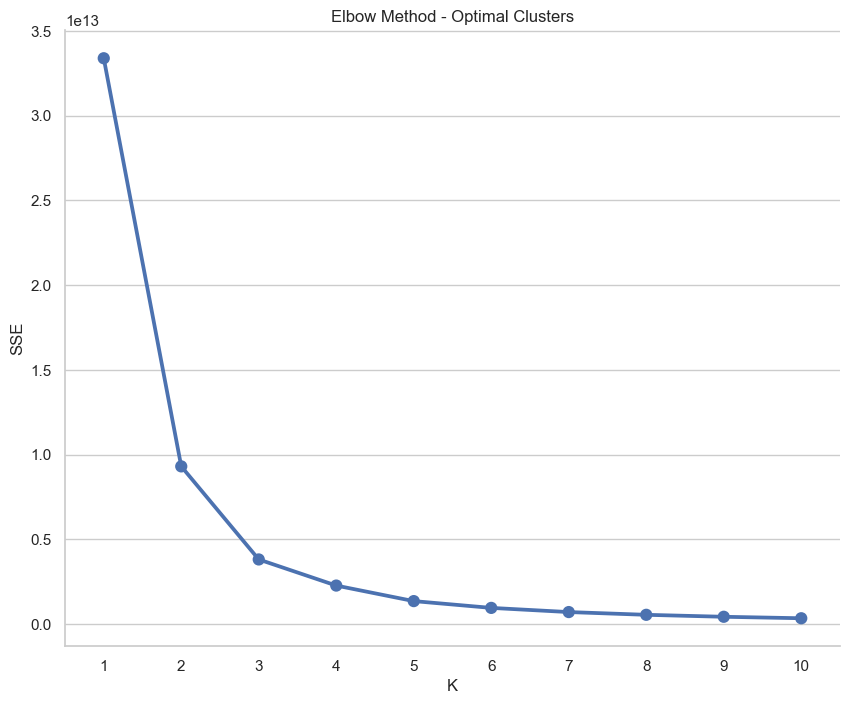

In [60]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.despine(left=False, bottom=False)

ax.set_title('Elbow Method - Optimal Clusters')

ax.set_xlabel('K')

ax.set_ylabel('SSE')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

The elbow is showing sharp bends at 3 and 2 clusters. 

### Silhouette Scores 
#### A score closer to 1 indicated the data points are similar


In [61]:
for k in range(2,7):
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(rfm_normalized)

    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(k, silhouette_avg))

For n_clusters=2, the silhouette score is 0.6105246528967682
For n_clusters=3, the silhouette score is 0.59580598542296
For n_clusters=4, the silhouette score is 0.5615010477522309
For n_clusters=5, the silhouette score is 0.5708677081208281
For n_clusters=6, the silhouette score is 0.5581860002592766


Due to our business use, we'll keep using 3 clusters. However, I'd like to see if simplifying the clusters to the optimal 2 listed in the Shilouette analysis will give us better future modeling results. 

In [63]:
Kmeans = KMeans(n_clusters=2, random_state=42)

Kmeans.fit(rfm_normalized)

cluster_labels = Kmeans.labels_

#Create a dataframe with new cluster labels
fm_kmeans2 = rfm.assign(FM_Cluster=cluster_labels)

#Group data by cluster and calculate average RFM values and segment size per cluster
fm_kmeans2_agg = fm_kmeans2.groupby(['FM_Cluster']).agg({'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

print(fm_kmeans2_agg)

           Frequency Monetary       
                mean     mean  count
FM_Cluster                          
0                3.1    457.5  40459
1                3.1    522.0  23211


Compared to 3 clusters

In [64]:
print(fm_kmeans3_agg)

           Frequency Monetary       
                mean     mean  count
FM_Cluster                          
0                3.1    419.6  24339
1                3.1    554.2  15979
2                3.1    495.0  23352


--------------------------------------------------------------------------------------------------------------------------------------------

Compared with the manual segmentation

           Frequency Monetary   

                mean     mean  count

FM_Segment  
                        
     Low              2.3    320.3  28876

     Middle           2.6    388.0  20259

     Top              5.4    929.9  14535

It's obvious that the manual segmentation of the data based on conditions gave us the most diverse clusters and also leaves less room for undervaluing customers. The manual RFM segmenation would likely be te best candiate for the attrition predictions. It would be a good idea to explore the other features of these clusters for more insight.

### Snake Plot of KMeans RFM Clusters

In [70]:
hotel_customer_rfm_cluster_melt = pd.melt(hotel_customer_rfm_clustered.reset_index(),                     
    id_vars=['ID', 'FM_Cluster'],                    
    value_vars=['Recency','Frequency', 'Monetary'],                     
    var_name='Attribute',                     
    value_name='Value')

<AxesSubplot:title={'center':'Snake plot of RFM Clusters'}, xlabel='Attribute', ylabel='Value'>

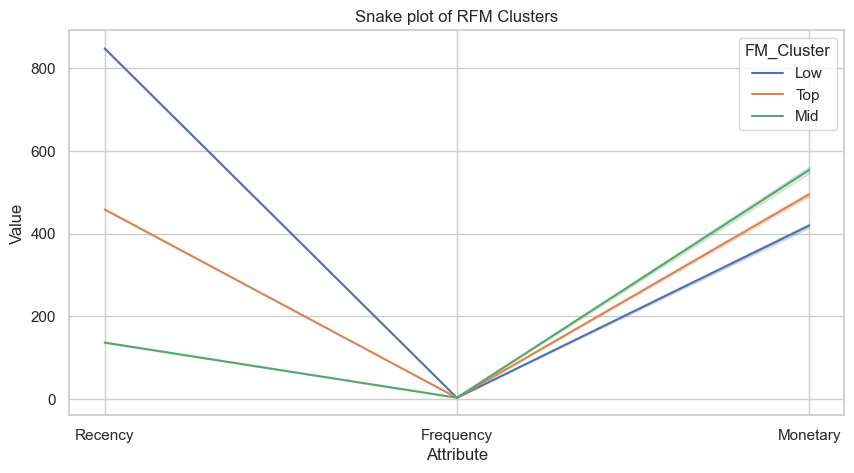

In [71]:
plt.title('Snake plot of RFM Clusters')
sns.lineplot(x="Attribute", y="Value", hue='FM_Cluster', data=hotel_customer_rfm_cluster_melt)


### Snake Plot of manual RFM Segments

In [67]:
hotel_customer_rfm_melt = pd.melt(hotel_customer_rfm.reset_index(),                     
    id_vars=['ID', 'FM_Segment'],                    
    value_vars=['Recency', 'Frequency', 'Monetary'],                     
    var_name='Attribute',                     
    value_name='Value')

<AxesSubplot:title={'center':'Snake plot of RFM Segments'}, xlabel='Attribute', ylabel='Value'>

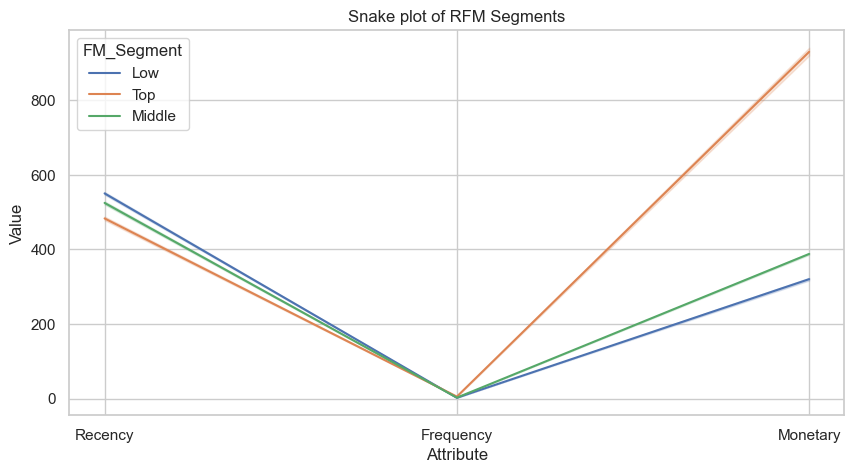

In [69]:
plt.title('Snake plot of RFM Segments')
sns.lineplot(x="Attribute", y="Value", hue='FM_Segment', data=hotel_customer_rfm_melt)


Again there is more variation in the Recency and Monetary scores in the manual segments that can be seen here. 

 ### Heatmap Relative Importance KMeans Clusters

In [73]:
cluster_avg = fm_kmeans3.groupby(['FM_Cluster']).mean()
population_avg = rfm.mean()
relative_imp = cluster_avg/population_avg - 1
relative_imp = relative_imp.round(2)
print(relative_imp)

              ID  Recency  Frequency  Monetary
FM_Cluster                                    
Low        -0.63     0.61      -0.01     -0.13
Mid         0.90    -0.74       0.01      0.15
Top         0.04    -0.13       0.00      0.03


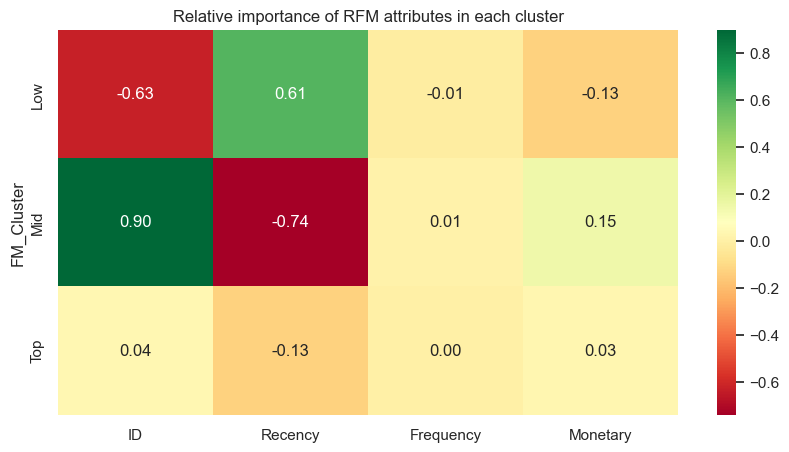

In [74]:
plt.figure(figsize=(10,5))
plt.title('Relative importance of RFM attributes in each cluster')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Insights: 

* Recency is the most important attribute in the Top and Mid clusters.

 ### Heatmap Relative Importance manual RFM Segments

In [75]:
cluster_avg2 = hotel_customer_rfm.groupby(['FM_Segment']).mean()
population_avg2 = rfm.mean()
relative_imp2 = cluster_avg2/population_avg2 - 1
relative_imp2 = relative_imp2.round(2)
print(relative_imp2[['Recency','Frequency', 'Monetary']])

            Recency  Frequency  Monetary
FM_Segment                              
Low            0.04      -0.26     -0.33
Middle        -0.00      -0.16     -0.19
Top           -0.08       0.73      0.93


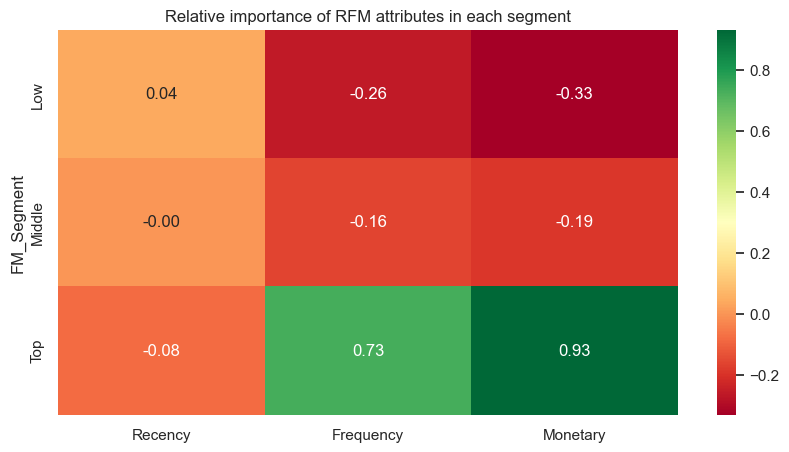

In [76]:
plt.figure(figsize=(10,5))
plt.title('Relative importance of RFM attributes in each segment')
sns.heatmap(data=relative_imp2[['Recency','Frequency', 'Monetary']], annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Insights:

* The Low segment is almost equally impacted by all attributes. 
* The Middle segement is not highly impacted by any attributes.
* The Top segment is predominatly impact by the Monetary attribute as we saw in the clustering. 
* The most impactful attribute is Recency attribute in the Low segment. 

### Cluster on all Features

Creating 2 complete modeling ready dataframes with only relevant features that will be used for clustering and classification predictions. 

### Manual RFM Segmentation Set

Reveiew featuers and keep only the relevant variables that will provide meaning in our cluster analysis. 

In [77]:
hotel_customer_rfm.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   4         FRA  60.0               1095               93           240.0   
3   6         JPN  54.0               1095               58           230.0   
4   8         FRA  32.0               1095               38           535.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2          60.0                 0                 0                  1  ...   
3          24.0                 0                 0                  1  ...   
4          94.0                 0                 0                  1  ...   

   TotalRevenue  Attrition  Recency  Frequency Monetary  M  F  RFM_Score  \
0         476.3      False      151          5    476.3  2  3        5.0   
1         333.0       True     1100          5    333.0  2  3        5.0   
2         300.0       True     1100          5    300.0  2  3        5.0   
3         254.0       True     1097          2    254.0  1  1        2.0   
4         629.0       True     1100          5    629.0  3  3        6.0   

   FM_Score  FM_Segment  
0       5.0         Low  
1       5.0         Low  
2       5.0         Low  
3       2.0         Low  
4       6.0         Top  

[5 rows x 40 columns]

Remove - ID, Nationality, Total Revenue, DaysSinceLastStay, Room_Nights. Undecided if I need to remove the indivdual RFM scores. 

In [78]:
model_hotel_customer_rfm = hotel_customer_rfm.drop(['Nationality', 'TotalRevenue', 'DaysSinceLastStay', 'RoomNights'], axis=1)

In [79]:
cat_hotel_customer_rfm = model_hotel_customer_rfm.select_dtypes(include = 'object').copy()
cat_hotel_customer_rfm.head(2).T

0                      1
DistributionChannel  Corporate  Travel Agent/Operator
MarketSegment        Corporate  Travel Agent/Operator
Country                    PRT                    PRT
FM_Segment                 Low                    Low

#### Dummy Encoding Categorical Features

Merge newly encoded variables with RFM segment modeling dataframe

In [81]:
dummies1 = pd.get_dummies(cat_hotel_customer_rfm, prefix={'DistributionChannel':'DistChannel',
                                                'MarketSegment':'MrkSegment',
                                                'Country': 'CTRY',
                                                'FM_Segment':'FM_Seg'}, drop_first=False)

model_hotel_customer_rfm = pd.concat([model_hotel_customer_rfm, dummies1], axis='columns')

model_hotel_customer_rfm.head()

ID   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  OtherRevenue  \
0   1  51.0                150               45           371.0         105.3   
1   2   0.0               1095               61           280.0          53.0   
2   4  60.0               1095               93           240.0          60.0   
3   6  54.0               1095               58           230.0          24.0   
4   8  32.0               1095               38           535.0          94.0   

   BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  PersonsNights  ...  \
0                 1                 0                  3              8  ...   
1                 0                 0                  1             10  ...   
2                 0                 0                  1             10  ...   
3                 0                 0                  1              4  ...   
4                 0                 0                  1             10  ...   

   CTRY_GBR CTRY_ITA CTRY_NLD  CTRY_Other  CTRY_PRT  CTRY_SWE  CTRY_USA  \
0         0        0        0           0         1         0         0   
1         0        0        0           0         1         0         0   
2         0        0        0           0         0         0         0   
3         0        0        0           1         0         0         0   
4         0        0        0           0         0         0         0   

   FM_Seg_Low  FM_Seg_Middle  FM_Seg_Top  
0           1              0           0  
1           1              0           0  
2           1              0           0  
3           1              0           0  
4           0              0           1  

[5 rows x 65 columns]

In [82]:
model_hotel_customer_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 63669
Data columns (total 65 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   ID                                   63670 non-null  int64   
 1   Age                                  63670 non-null  float64 
 2   DaysSinceCreation                    63670 non-null  int64   
 3   AverageLeadTime                      63670 non-null  int64   
 4   LodgingRevenue                       63670 non-null  float64 
 5   OtherRevenue                         63670 non-null  float64 
 6   BookingsCanceled                     63670 non-null  int64   
 7   BookingsNoShowed                     63670 non-null  int64   
 8   BookingsCheckedIn                    63670 non-null  int64   
 9   PersonsNights                        63670 non-null  int64   
 10  DaysSinceFirstStay                   63670 non-null  int64   
 11  DistributionCha

In [83]:
model_hotel_customer_rfm.FM_Segment.value_counts()

Low       28876
Middle    20259
Top       14535
Name: FM_Segment, dtype: int64

In [84]:
model_hotel_customer_rfm['FM_Seg_Low']

0        1
1        1
2        1
3        1
4        0
        ..
63665    0
63666    1
63667    1
63668    1
63669    1
Name: FM_Seg_Low, Length: 63670, dtype: uint8

In [85]:
model_hotel_customer_rfm.drop(['DistributionChannel', 'MarketSegment', 'Country', 'FM_Segment' ], axis='columns', inplace=True)
model_hotel_customer_rfm

ID   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0          1  51.0                150               45           371.0   
1          2   0.0               1095               61           280.0   
2          4  60.0               1095               93           240.0   
3          6  54.0               1095               58           230.0   
4          8  32.0               1095               38           535.0   
...      ...   ...                ...              ...             ...   
63665  83581  48.0                  0               20           176.0   
63666  83583  49.0                  0               91           143.0   
63667  83585  52.0                  0              116           336.9   
63668  83587  47.0                  0              109           327.1   
63669  83589  85.0                  0              109           981.3   

       OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  \
0             105.3                 1                 0                  3   
1              53.0                 0                 0                  1   
2              60.0                 0                 0                  1   
3              24.0                 0                 0                  1   
4              94.0                 0                 0                  1   
...             ...               ...               ...                ...   
63665         147.0                 0                 0                  1   
63666           2.0                 0                 0                  1   
63667         105.5                 0                 0                  1   
63668         277.5                 0                 0                  1   
63669           9.0                 0                 0                  1   

       PersonsNights  ...  CTRY_GBR  CTRY_ITA  CTRY_NLD  CTRY_Other  CTRY_PRT  \
0                  8  ...         0         0         0           0         1   
1                 10  ...         0         0         0           0         1   
2                 10  ...         0         0         0           0         0   
3                  4  ...         0         0         0           1         0   
4                 10  ...         0         0         0           0         0   
...              ...  ...       ...       ...       ...         ...       ...   
63665              4  ...         0         0         0           0         0   
63666              2  ...         0         0         0           0         0   
63667              8  ...         0         1         0           0         0   
63668              6  ...         0         0         0           1         0   
63669              6  ...         0         0         0           1         0   

       CTRY_SWE  CTRY_USA  FM_Seg_Low  FM_Seg_Middle  FM_Seg_Top  
0             0         0           1              0           0  
1             0         0           1              0           0  
2             0         0           1              0           0  
3             0         0           1              0           0  
4             0         0           0              0           1  
...         ...       ...         ...            ...         ...  
63665         0         0           0              1           0  
63666         0         0           1              0           0  
63667         0         0           1              0           0  
63668         0         0           1              0           0  
63669         0         0           1              0           0  

[63670 rows x 61 columns]

Should all be numerical values

In [86]:
model_hotel_customer_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 63669
Data columns (total 61 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   ID                                   63670 non-null  int64   
 1   Age                                  63670 non-null  float64 
 2   DaysSinceCreation                    63670 non-null  int64   
 3   AverageLeadTime                      63670 non-null  int64   
 4   LodgingRevenue                       63670 non-null  float64 
 5   OtherRevenue                         63670 non-null  float64 
 6   BookingsCanceled                     63670 non-null  int64   
 7   BookingsNoShowed                     63670 non-null  int64   
 8   BookingsCheckedIn                    63670 non-null  int64   
 9   PersonsNights                        63670 non-null  int64   
 10  DaysSinceFirstStay                   63670 non-null  int64   
 11  SRHighFloor    

I've decided to remove the F, M, separate scores as they are the origin feature of RFM score and derived from the original Recency Frequency and Monetary features. They are also much better for interpretability. 


In [87]:
model_hotel_customer_rfm = model_hotel_customer_rfm.drop(['F', 'M'], axis=1)

remove the ID as it has important meaning but should not be used to model. We'll add it back to the output for interpretation. 

In [88]:
CustomerID = model_hotel_customer_rfm['ID']

In [89]:
model_hotel_customer_rfm = model_hotel_customer_rfm.drop(['ID'], axis=1)

In [90]:
model_hotel_customer_rfm

Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  OtherRevenue  \
0      51.0                150               45           371.0         105.3   
1       0.0               1095               61           280.0          53.0   
2      60.0               1095               93           240.0          60.0   
3      54.0               1095               58           230.0          24.0   
4      32.0               1095               38           535.0          94.0   
...     ...                ...              ...             ...           ...   
63665  48.0                  0               20           176.0         147.0   
63666  49.0                  0               91           143.0           2.0   
63667  52.0                  0              116           336.9         105.5   
63668  47.0                  0              109           327.1         277.5   
63669  85.0                  0              109           981.3           9.0   

       BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  PersonsNights  \
0                     1                 0                  3              8   
1                     0                 0                  1             10   
2                     0                 0                  1             10   
3                     0                 0                  1              4   
4                     0                 0                  1             10   
...                 ...               ...                ...            ...   
63665                 0                 0                  1              4   
63666                 0                 0                  1              2   
63667                 0                 0                  1              8   
63668                 0                 0                  1              6   
63669                 0                 0                  1              6   

       DaysSinceFirstStay  ...  CTRY_GBR  CTRY_ITA  CTRY_NLD  CTRY_Other  \
0                    1074  ...         0         0         0           0   
1                    1100  ...         0         0         0           0   
2                    1100  ...         0         0         0           0   
3                    1097  ...         0         0         0           1   
4                    1100  ...         0         0         0           0   
...                   ...  ...       ...       ...       ...         ...   
63665                   2  ...         0         0         0           0   
63666                   1  ...         0         0         0           0   
63667                   4  ...         0         1         0           0   
63668                   3  ...         0         0         0           1   
63669                   3  ...         0         0         0           1   

       CTRY_PRT  CTRY_SWE  CTRY_USA  FM_Seg_Low  FM_Seg_Middle  FM_Seg_Top  
0             1         0         0           1              0           0  
1             1         0         0           1              0           0  
2             0         0         0           1              0           0  
3             0         0         0           1              0           0  
4             0         0         0           0              0           1  
...         ...       ...       ...         ...            ...         ...  
63665         0         0         0           0              1           0  
63666         0         0         0           1              0           0  
63667         0         0         0           1              0           0  
63668         0         0         0           1              0           0  
63669         0         0         0           1              0           0  

[63670 rows x 58 columns]

#### Normalize entire manual RFM segmentation dataframe wtih standardscaler

In [91]:
model_hotel_customer_rfm_norm = scaler.fit_transform(model_hotel_customer_rfm) 
model_hotel_customer_rfm_norm = pd.DataFrame(model_hotel_customer_rfm_norm, index=model_hotel_customer_rfm.index, columns=model_hotel_customer_rfm.columns)
model_hotel_customer_rfm_norm

Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0      0.334595          -1.243485        -0.459671       -0.055740   
1     -2.554614           1.875127        -0.284167       -0.294030   
2      0.844455           1.875127         0.066842       -0.398773   
3      0.504548           1.875127        -0.317074       -0.424959   
4     -0.741777           1.875127        -0.536454        0.373707   
...         ...                ...              ...             ...   
63665  0.164642          -1.738502        -0.733896       -0.566362   
63666  0.221293          -1.738502         0.044904       -0.652775   
63667  0.391246          -1.738502         0.319129       -0.145033   
63668  0.107990          -1.738502         0.242346       -0.170695   
63669  2.260734          -1.738502         0.242346        1.542378   

       OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  \
0          0.133990         13.109060         -0.024591           3.190277   
1         -0.289058         -0.034474         -0.024591          -0.070469   
2         -0.232436         -0.034474         -0.024591          -0.070469   
3         -0.523634         -0.034474         -0.024591          -0.070469   
4          0.042586         -0.034474         -0.024591          -0.070469   
...             ...               ...               ...                ...   
63665      0.471295         -0.034474         -0.024591          -0.070469   
63666     -0.701589         -0.034474         -0.024591          -0.070469   
63667      0.135607         -0.034474         -0.024591          -0.070469   
63668      1.526890         -0.034474         -0.024591          -0.070469   
63669     -0.644967         -0.034474         -0.024591          -0.070469   

       PersonsNights  DaysSinceFirstStay  ...  CTRY_GBR  CTRY_ITA  CTRY_NLD  \
0           0.440735            1.795864  ... -0.339121 -0.204716 -0.182901   
1           0.905566            1.881673  ... -0.339121 -0.204716 -0.182901   
2           0.905566            1.881673  ... -0.339121 -0.204716 -0.182901   
3          -0.488927            1.871772  ... -0.339121 -0.204716 -0.182901   
4           0.905566            1.881673  ... -0.339121 -0.204716 -0.182901   
...              ...                 ...  ...       ...       ...       ...   
63665      -0.488927           -1.742101  ... -0.339121 -0.204716 -0.182901   
63666      -0.953757           -1.745402  ... -0.339121 -0.204716 -0.182901   
63667       0.440735           -1.735501  ... -0.339121  4.884811 -0.182901   
63668      -0.024096           -1.738801  ... -0.339121 -0.204716 -0.182901   
63669      -0.024096           -1.738801  ... -0.339121 -0.204716 -0.182901   

       CTRY_Other  CTRY_PRT  CTRY_SWE  CTRY_USA  FM_Seg_Low  FM_Seg_Middle  \
0       -0.440174  2.377329 -0.120213 -0.199326    1.097700      -0.683139   
1       -0.440174  2.377329 -0.120213 -0.199326    1.097700      -0.683139   
2       -0.440174 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   
3        2.271831 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   
4       -0.440174 -0.420640 -0.120213 -0.199326   -0.910996      -0.683139   
...           ...       ...       ...       ...         ...            ...   
63665   -0.440174 -0.420640 -0.120213 -0.199326   -0.910996       1.463831   
63666   -0.440174 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   
63667   -0.440174 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   
63668    2.271831 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   
63669    2.271831 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   

       FM_Seg_Top  
0       -0.543891  
1       -0.543891  
2       -0.543891  
3       -0.543891  
4        1.838603  
...           ...  
63665   -0.543891  
63666   -0.543891  
63667   -0.543891  
63668   -0.543891  
63669   -0.543891  

[63670 rows x 58 columns]

#### Persona Clusters

Cluster RFM segment set using elbow method to test the correct amount of clusters. 

In [92]:
Kmeans = KMeans(n_clusters=5, random_state=42, max_iter=50)

Kmeans.fit(model_hotel_customer_rfm_norm)

cluster_labels2 = Kmeans.labels_

#Create a dataframe with new cluster labels
RFM_segment_kmeans3 = model_hotel_customer_rfm.assign(Persona_Cluster=cluster_labels2)

In [93]:

#Group data by cluster and calculate average RFM values and segment size per cluster
rfm_segment_kmeans3_agg = RFM_segment_kmeans3.groupby(['Persona_Cluster']).agg({'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

print(rfm_segment_kmeans3_agg)

                Frequency Monetary       
                     mean     mean  count
Persona_Cluster                          
0                     2.5    312.9  14240
1                     2.6    432.6   8064
2                     5.4    964.7  13349
3                     2.5    349.9  28017


In [95]:
model_hotel_customer_rfm_norm_persona = pd.merge(model_hotel_customer_rfm_norm, RFM_segment_kmeans3['Persona_Cluster'], left_index=True, right_index=True)

In [96]:
model_hotel_customer_rfm_norm_persona

Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0      0.334595          -1.243485        -0.459671       -0.055740   
1     -2.554614           1.875127        -0.284167       -0.294030   
2      0.844455           1.875127         0.066842       -0.398773   
3      0.504548           1.875127        -0.317074       -0.424959   
4     -0.741777           1.875127        -0.536454        0.373707   
...         ...                ...              ...             ...   
63665  0.164642          -1.738502        -0.733896       -0.566362   
63666  0.221293          -1.738502         0.044904       -0.652775   
63667  0.391246          -1.738502         0.319129       -0.145033   
63668  0.107990          -1.738502         0.242346       -0.170695   
63669  2.260734          -1.738502         0.242346        1.542378   

       OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  \
0          0.133990         13.109060         -0.024591           3.190277   
1         -0.289058         -0.034474         -0.024591          -0.070469   
2         -0.232436         -0.034474         -0.024591          -0.070469   
3         -0.523634         -0.034474         -0.024591          -0.070469   
4          0.042586         -0.034474         -0.024591          -0.070469   
...             ...               ...               ...                ...   
63665      0.471295         -0.034474         -0.024591          -0.070469   
63666     -0.701589         -0.034474         -0.024591          -0.070469   
63667      0.135607         -0.034474         -0.024591          -0.070469   
63668      1.526890         -0.034474         -0.024591          -0.070469   
63669     -0.644967         -0.034474         -0.024591          -0.070469   

       PersonsNights  DaysSinceFirstStay  ...  CTRY_ITA  CTRY_NLD  CTRY_Other  \
0           0.440735            1.795864  ... -0.204716 -0.182901   -0.440174   
1           0.905566            1.881673  ... -0.204716 -0.182901   -0.440174   
2           0.905566            1.881673  ... -0.204716 -0.182901   -0.440174   
3          -0.488927            1.871772  ... -0.204716 -0.182901    2.271831   
4           0.905566            1.881673  ... -0.204716 -0.182901   -0.440174   
...              ...                 ...  ...       ...       ...         ...   
63665      -0.488927           -1.742101  ... -0.204716 -0.182901   -0.440174   
63666      -0.953757           -1.745402  ... -0.204716 -0.182901   -0.440174   
63667       0.440735           -1.735501  ...  4.884811 -0.182901   -0.440174   
63668      -0.024096           -1.738801  ... -0.204716 -0.182901    2.271831   
63669      -0.024096           -1.738801  ... -0.204716 -0.182901    2.271831   

       CTRY_PRT  CTRY_SWE  CTRY_USA  FM_Seg_Low  FM_Seg_Middle  FM_Seg_Top  \
0      2.377329 -0.120213 -0.199326    1.097700      -0.683139   -0.543891   
1      2.377329 -0.120213 -0.199326    1.097700      -0.683139   -0.543891   
2     -0.420640 -0.120213 -0.199326    1.097700      -0.683139   -0.543891   
3     -0.420640 -0.120213 -0.199326    1.097700      -0.683139   -0.543891   
4     -0.420640 -0.120213 -0.199326   -0.910996      -0.683139    1.838603   
...         ...       ...       ...         ...            ...         ...   
63665 -0.420640 -0.120213 -0.199326   -0.910996       1.463831   -0.543891   
63666 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   -0.543891   
63667 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   -0.543891   
63668 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   -0.543891   
63669 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   -0.543891   

       Persona_Cluster  
0                    3  
1                    0  
2                    0  
3                    0  
4                    2  
...                ...  
63665                3  
63666                3  
63667                3  
63668                3  
63669                3  

[63670 rows

#### Elbow method

In [97]:
sse={}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(model_hotel_customer_rfm_norm)
    sse[k] = kmeans.inertia_

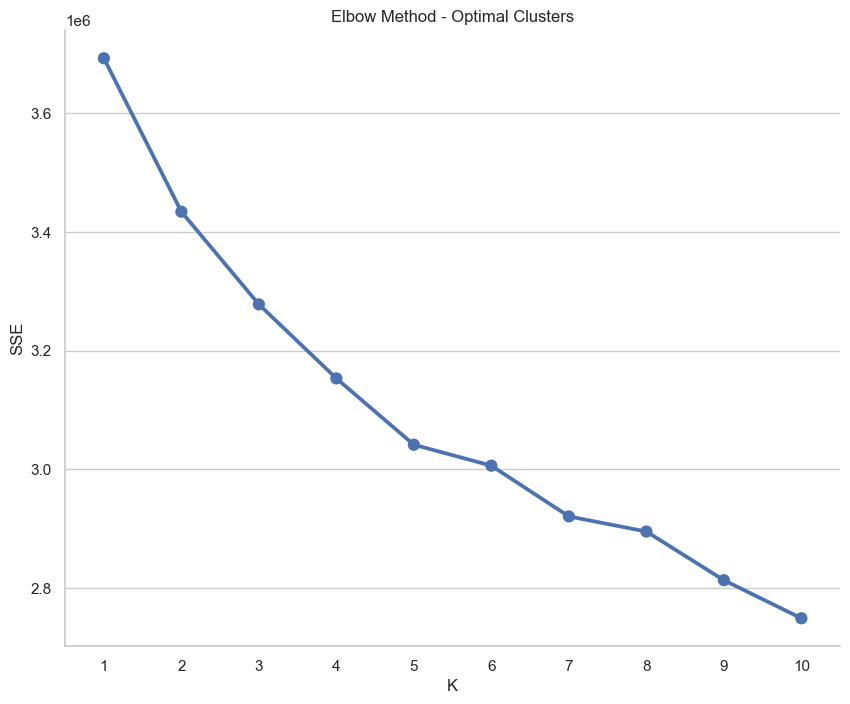

In [98]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.despine(left=False, bottom=False)

ax.set_title('Elbow Method - Optimal Clusters')

ax.set_xlabel('K')

ax.set_ylabel('SSE')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### KMeans RFM Clusters Set

In [99]:
hotel_customer_rfm_clustered.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   4         FRA  60.0               1095               93           240.0   
3   6         JPN  54.0               1095               58           230.0   
4   8         FRA  32.0               1095               38           535.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2          60.0                 0                 0                  1  ...   
3          24.0                 0                 0                  1  ...   
4          94.0                 0                 0                  1  ...   

   SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom  Country  \
0                   0                     0            0      PRT   
1                   0                     0            0      PRT   
2                   0                     0            0      FRA   
3                   0                     0            0    Other   
4                   0                     0            0      FRA   

  TotalRevenue Attrition  Recency  Frequency  Monetary  FM_Cluster  
0        476.3     False      151          5     476.3         Low  
1        333.0      True     1100          5     333.0         Low  
2        300.0      True     1100          5     300.0         Low  
3        254.0      True     1097          2     254.0         Low  
4        629.0      True     1100          5     629.0         Low  

[5 rows x 36 columns]

In [100]:
model_hotel_customer_rfm_cluster = hotel_customer_rfm_clustered.drop(['Nationality', 'TotalRevenue', 'DaysSinceLastStay', 'RoomNights'], axis=1)

In [101]:
cat_hotel_customer_rfm_cluster = model_hotel_customer_rfm_cluster.select_dtypes(include = 'object').copy()
cat_hotel_customer_rfm_cluster.head(2).T

0                      1
DistributionChannel  Corporate  Travel Agent/Operator
MarketSegment        Corporate  Travel Agent/Operator
Country                    PRT                    PRT
FM_Cluster                 Low                    Low

#### Dummy Encoding Categorical Features
Merge newly encoded variables with RFM segment modeling dataframe

In [103]:
dummies2 = pd.get_dummies(cat_hotel_customer_rfm_cluster, prefix={'DistributionChannel':'DistChannel',
                                                'MarketSegment':'MrkSegment',
                                                'Country': 'CTRY',
                                                'FM_Cluster':'FM_Clus'}, drop_first=False)

model_hotel_customer_rfm_cluster = pd.concat([model_hotel_customer_rfm_cluster, dummies2], axis='columns')

model_hotel_customer_rfm_cluster.head()

ID   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  OtherRevenue  \
0   1  51.0                150               45           371.0         105.3   
1   2   0.0               1095               61           280.0          53.0   
2   4  60.0               1095               93           240.0          60.0   
3   6  54.0               1095               58           230.0          24.0   
4   8  32.0               1095               38           535.0          94.0   

   BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  PersonsNights  ...  \
0                 1                 0                  3              8  ...   
1                 0                 0                  1             10  ...   
2                 0                 0                  1             10  ...   
3                 0                 0                  1              4  ...   
4                 0                 0                  1             10  ...   

   CTRY_GBR CTRY_ITA CTRY_NLD  CTRY_Other  CTRY_PRT  CTRY_SWE  CTRY_USA  \
0         0        0        0           0         1         0         0   
1         0        0        0           0         1         0         0   
2         0        0        0           0         0         0         0   
3         0        0        0           1         0         0         0   
4         0        0        0           0         0         0         0   

   FM_Clus_Low  FM_Clus_Mid  FM_Clus_Top  
0            1            0            0  
1            1            0            0  
2            1            0            0  
3            1            0            0  
4            1            0            0  

[5 rows x 61 columns]

In [104]:
model_hotel_customer_rfm_cluster.drop(['DistributionChannel', 'MarketSegment', 'Country', 'FM_Cluster' ], axis='columns', inplace=True)
model_hotel_customer_rfm_cluster

ID   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0          1  51.0                150               45           371.0   
1          2   0.0               1095               61           280.0   
2          4  60.0               1095               93           240.0   
3          6  54.0               1095               58           230.0   
4          8  32.0               1095               38           535.0   
...      ...   ...                ...              ...             ...   
63665  83581  48.0                  0               20           176.0   
63666  83583  49.0                  0               91           143.0   
63667  83585  52.0                  0              116           336.9   
63668  83587  47.0                  0              109           327.1   
63669  83589  85.0                  0              109           981.3   

       OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  \
0             105.3                 1                 0                  3   
1              53.0                 0                 0                  1   
2              60.0                 0                 0                  1   
3              24.0                 0                 0                  1   
4              94.0                 0                 0                  1   
...             ...               ...               ...                ...   
63665         147.0                 0                 0                  1   
63666           2.0                 0                 0                  1   
63667         105.5                 0                 0                  1   
63668         277.5                 0                 0                  1   
63669           9.0                 0                 0                  1   

       PersonsNights  ...  CTRY_GBR  CTRY_ITA  CTRY_NLD  CTRY_Other  CTRY_PRT  \
0                  8  ...         0         0         0           0         1   
1                 10  ...         0         0         0           0         1   
2                 10  ...         0         0         0           0         0   
3                  4  ...         0         0         0           1         0   
4                 10  ...         0         0         0           0         0   
...              ...  ...       ...       ...       ...         ...       ...   
63665              4  ...         0         0         0           0         0   
63666              2  ...         0         0         0           0         0   
63667              8  ...         0         1         0           0         0   
63668              6  ...         0         0         0           1         0   
63669              6  ...         0         0         0           1         0   

       CTRY_SWE  CTRY_USA  FM_Clus_Low  FM_Clus_Mid  FM_Clus_Top  
0             0         0            1            0            0  
1             0         0            1            0            0  
2             0         0            1            0            0  
3             0         0            1            0            0  
4             0         0            1            0            0  
...         ...       ...          ...          ...          ...  
63665         0         0            0            1            0  
63666         0         0            0            1            0  
63667         0         0            0            1            0  
63668         0         0            0            1            0  
63669         0         0            0            1            0  

[63670 rows x 57 columns]

Should all be numerical values

In [105]:
model_hotel_customer_rfm_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63670 entries, 0 to 63669
Data columns (total 57 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   63670 non-null  int64  
 1   Age                                  63670 non-null  float64
 2   DaysSinceCreation                    63670 non-null  int64  
 3   AverageLeadTime                      63670 non-null  int64  
 4   LodgingRevenue                       63670 non-null  float64
 5   OtherRevenue                         63670 non-null  float64
 6   BookingsCanceled                     63670 non-null  int64  
 7   BookingsNoShowed                     63670 non-null  int64  
 8   BookingsCheckedIn                    63670 non-null  int64  
 9   PersonsNights                        63670 non-null  int64  
 10  DaysSinceFirstStay                   63670 non-null  int64  
 11  SRHighFloor                 

Remove the ID as it has important meaning but should not be used to model. We'll add it back to the output for interpretation. 

In [106]:
model_hotel_customer_rfm_cluster = model_hotel_customer_rfm_cluster.drop(['ID'], axis=1)

In [107]:
model_hotel_customer_rfm_cluster.head()

Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  OtherRevenue  \
0  51.0                150               45           371.0         105.3   
1   0.0               1095               61           280.0          53.0   
2  60.0               1095               93           240.0          60.0   
3  54.0               1095               58           230.0          24.0   
4  32.0               1095               38           535.0          94.0   

   BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  PersonsNights  \
0                 1                 0                  3              8   
1                 0                 0                  1             10   
2                 0                 0                  1             10   
3                 0                 0                  1              4   
4                 0                 0                  1             10   

   DaysSinceFirstStay  ...  CTRY_GBR  CTRY_ITA  CTRY_NLD  CTRY_Other  \
0                1074  ...         0         0         0           0   
1                1100  ...         0         0         0           0   
2                1100  ...         0         0         0           0   
3                1097  ...         0         0         0           1   
4                1100  ...         0         0         0           0   

   CTRY_PRT  CTRY_SWE  CTRY_USA  FM_Clus_Low  FM_Clus_Mid  FM_Clus_Top  
0         1         0         0            1            0            0  
1         1         0         0            1            0            0  
2         0         0         0            1            0            0  
3         0         0         0            1            0            0  
4         0         0         0            1            0            0  

[5 rows x 56 columns]

Normalize entire KMeans RFM clustering dataframe wtih standardscaler

In [108]:
model_hotel_customer_rfm_cluster_norm = scaler.fit_transform(model_hotel_customer_rfm_cluster) 
model_hotel_customer_rfm_cluster_norm = pd.DataFrame(model_hotel_customer_rfm_cluster_norm, index=model_hotel_customer_rfm_cluster.index, columns=model_hotel_customer_rfm_cluster.columns)
model_hotel_customer_rfm_cluster_norm

Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0      0.334595          -1.243485        -0.459671       -0.055740   
1     -2.554614           1.875127        -0.284167       -0.294030   
2      0.844455           1.875127         0.066842       -0.398773   
3      0.504548           1.875127        -0.317074       -0.424959   
4     -0.741777           1.875127        -0.536454        0.373707   
...         ...                ...              ...             ...   
63665  0.164642          -1.738502        -0.733896       -0.566362   
63666  0.221293          -1.738502         0.044904       -0.652775   
63667  0.391246          -1.738502         0.319129       -0.145033   
63668  0.107990          -1.738502         0.242346       -0.170695   
63669  2.260734          -1.738502         0.242346        1.542378   

       OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  \
0          0.133990         13.109060         -0.024591           3.190277   
1         -0.289058         -0.034474         -0.024591          -0.070469   
2         -0.232436         -0.034474         -0.024591          -0.070469   
3         -0.523634         -0.034474         -0.024591          -0.070469   
4          0.042586         -0.034474         -0.024591          -0.070469   
...             ...               ...               ...                ...   
63665      0.471295         -0.034474         -0.024591          -0.070469   
63666     -0.701589         -0.034474         -0.024591          -0.070469   
63667      0.135607         -0.034474         -0.024591          -0.070469   
63668      1.526890         -0.034474         -0.024591          -0.070469   
63669     -0.644967         -0.034474         -0.024591          -0.070469   

       PersonsNights  DaysSinceFirstStay  ...  CTRY_GBR  CTRY_ITA  CTRY_NLD  \
0           0.440735            1.795864  ... -0.339121 -0.204716 -0.182901   
1           0.905566            1.881673  ... -0.339121 -0.204716 -0.182901   
2           0.905566            1.881673  ... -0.339121 -0.204716 -0.182901   
3          -0.488927            1.871772  ... -0.339121 -0.204716 -0.182901   
4           0.905566            1.881673  ... -0.339121 -0.204716 -0.182901   
...              ...                 ...  ...       ...       ...       ...   
63665      -0.488927           -1.742101  ... -0.339121 -0.204716 -0.182901   
63666      -0.953757           -1.745402  ... -0.339121 -0.204716 -0.182901   
63667       0.440735           -1.735501  ... -0.339121  4.884811 -0.182901   
63668      -0.024096           -1.738801  ... -0.339121 -0.204716 -0.182901   
63669      -0.024096           -1.738801  ... -0.339121 -0.204716 -0.182901   

       CTRY_Other  CTRY_PRT  CTRY_SWE  CTRY_USA  FM_Clus_Low  FM_Clus_Mid  \
0       -0.440174  2.377329 -0.120213 -0.199326     1.271207    -0.578837   
1       -0.440174  2.377329 -0.120213 -0.199326     1.271207    -0.578837   
2       -0.440174 -0.420640 -0.120213 -0.199326     1.271207    -0.578837   
3        2.271831 -0.420640 -0.120213 -0.199326     1.271207    -0.578837   
4       -0.440174 -0.420640 -0.120213 -0.199326     1.271207    -0.578837   
...           ...       ...       ...       ...          ...          ...   
63665   -0.440174 -0.420640 -0.120213 -0.199326    -0.786654     1.727601   
63666   -0.440174 -0.420640 -0.120213 -0.199326    -0.786654     1.727601   
63667   -0.440174 -0.420640 -0.120213 -0.199326    -0.786654     1.727601   
63668    2.271831 -0.420640 -0.120213 -0.199326    -0.786654     1.727601   
63669    2.271831 -0.420640 -0.120213 -0.199326    -0.786654     1.727601   

       FM_Clus_Top  
0        -0.761049  
1        -0.761049  
2        -0.761049  
3        -0.761049  
4        -0.761049  
...            ...  
63665    -0.761049  
63666    -0.761049  
63667    -0.761049  
63668    -0.761049  
63669    -0.761049  

[63670 rows x 56 columns]

#### Persona Cluster

Cluster RFM Segment modeling set for persona clusters using the elbow method to detect the most optimal amount of clusters.

In [154]:
Kmeans = KMeans(n_clusters=6, random_state=42, max_iter=50)

Kmeans.fit(model_hotel_customer_rfm_cluster_norm)

cluster_labels3 = Kmeans.labels_

#Create a dataframe with new cluster labels
FM_cluster_kmeans3 = model_hotel_customer_rfm_cluster.assign(Persona_Cluster=cluster_labels3)

In [155]:
#Group data by cluster and calculate average RFM values and segment size per cluster
fm_cluster_kmeans3_agg = FM_cluster_kmeans3.groupby(['Persona_Cluster']).agg({'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

print(fm_cluster_kmeans3_agg)

                Frequency Monetary       
                     mean     mean  count
Persona_Cluster                          
0                     3.2    557.7  12704
1                     2.8    511.1   8225
2                     3.1    413.0  20431
3                     3.4    435.5   2380
4                     3.2    492.3  19331
5                     3.2    577.0    599


In [156]:
model_hotel_customer_rfm_cluster_norm_persona = pd.merge(model_hotel_customer_rfm_cluster_norm, FM_cluster_kmeans3['Persona_Cluster'], left_index=True, right_index=True)

In [157]:
model_hotel_customer_rfm_cluster_norm_persona

Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0      0.334595          -1.243485        -0.459671       -0.055740   
1     -2.554614           1.875127        -0.284167       -0.294030   
2      0.844455           1.875127         0.066842       -0.398773   
3      0.504548           1.875127        -0.317074       -0.424959   
4     -0.741777           1.875127        -0.536454        0.373707   
...         ...                ...              ...             ...   
63665  0.164642          -1.738502        -0.733896       -0.566362   
63666  0.221293          -1.738502         0.044904       -0.652775   
63667  0.391246          -1.738502         0.319129       -0.145033   
63668  0.107990          -1.738502         0.242346       -0.170695   
63669  2.260734          -1.738502         0.242346        1.542378   

       OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  \
0          0.133990         13.109060         -0.024591           3.190277   
1         -0.289058         -0.034474         -0.024591          -0.070469   
2         -0.232436         -0.034474         -0.024591          -0.070469   
3         -0.523634         -0.034474         -0.024591          -0.070469   
4          0.042586         -0.034474         -0.024591          -0.070469   
...             ...               ...               ...                ...   
63665      0.471295         -0.034474         -0.024591          -0.070469   
63666     -0.701589         -0.034474         -0.024591          -0.070469   
63667      0.135607         -0.034474         -0.024591          -0.070469   
63668      1.526890         -0.034474         -0.024591          -0.070469   
63669     -0.644967         -0.034474         -0.024591          -0.070469   

       PersonsNights  DaysSinceFirstStay  ...  CTRY_ITA  CTRY_NLD  CTRY_Other  \
0           0.440735            1.795864  ... -0.204716 -0.182901   -0.440174   
1           0.905566            1.881673  ... -0.204716 -0.182901   -0.440174   
2           0.905566            1.881673  ... -0.204716 -0.182901   -0.440174   
3          -0.488927            1.871772  ... -0.204716 -0.182901    2.271831   
4           0.905566            1.881673  ... -0.204716 -0.182901   -0.440174   
...              ...                 ...  ...       ...       ...         ...   
63665      -0.488927           -1.742101  ... -0.204716 -0.182901   -0.440174   
63666      -0.953757           -1.745402  ... -0.204716 -0.182901   -0.440174   
63667       0.440735           -1.735501  ...  4.884811 -0.182901   -0.440174   
63668      -0.024096           -1.738801  ... -0.204716 -0.182901    2.271831   
63669      -0.024096           -1.738801  ... -0.204716 -0.182901    2.271831   

       CTRY_PRT  CTRY_SWE  CTRY_USA  FM_Clus_Low  FM_Clus_Mid  FM_Clus_Top  \
0      2.377329 -0.120213 -0.199326     1.271207    -0.578837    -0.761049   
1      2.377329 -0.120213 -0.199326     1.271207    -0.578837    -0.761049   
2     -0.420640 -0.120213 -0.199326     1.271207    -0.578837    -0.761049   
3     -0.420640 -0.120213 -0.199326     1.271207    -0.578837    -0.761049   
4     -0.420640 -0.120213 -0.199326     1.271207    -0.578837    -0.761049   
...         ...       ...       ...          ...          ...          ...   
63665 -0.420640 -0.120213 -0.199326    -0.786654     1.727601    -0.761049   
63666 -0.420640 -0.120213 -0.199326    -0.786654     1.727601    -0.761049   
63667 -0.420640 -0.120213 -0.199326    -0.786654     1.727601    -0.761049   
63668 -0.420640 -0.120213 -0.199326    -0.786654     1.727601    -0.761049   
63669 -0.420640 -0.120213 -0.199326    -0.786654     1.727601    -0.761049   

       Persona_Cluster  
0                    3  
1                    2  
2                    2  
3                    2  
4                    2  
...                ...  
63665                0  
63666                0  
63667                0  
63668                0  
63669                0  

[63670 rows

#### Elbow Method

In [113]:
sse={}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(model_hotel_customer_rfm_cluster_norm)
    sse[k] = kmeans.inertia_

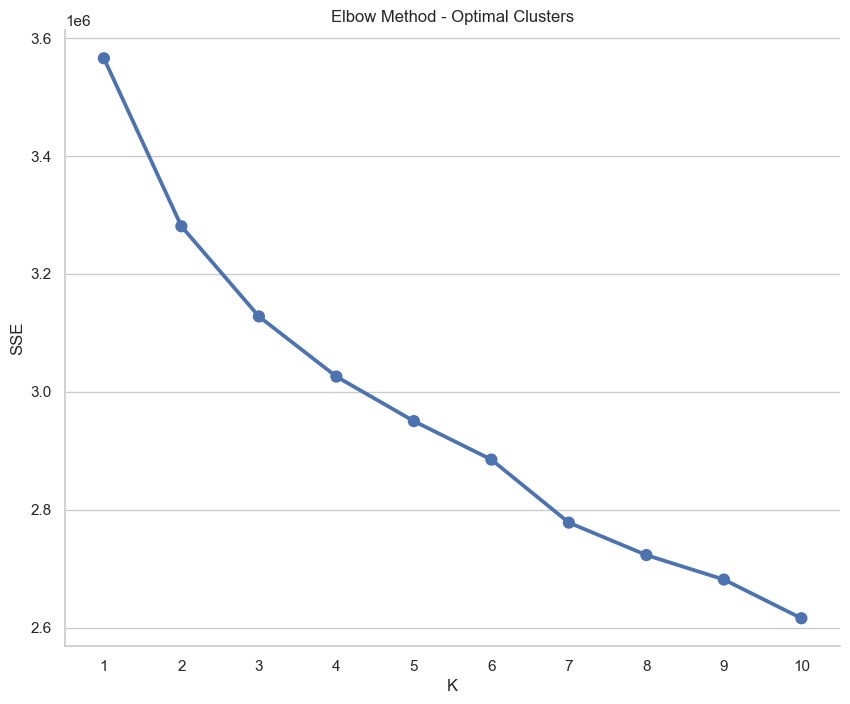

In [114]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.despine(left=False, bottom=False)

ax.set_title('Elbow Method - Optimal Clusters')

ax.set_xlabel('K')

ax.set_ylabel('SSE')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

## Cluster Analysis

#### Snake Plot for RFM Segement Set

In [116]:
snake_segment_persona = pd.merge(model_hotel_customer_rfm, RFM_segment_kmeans3['Persona_Cluster'], left_index=True, right_index=True)

In [117]:
snake_segment_persona = pd.merge(CustomerID, snake_segment_persona, left_index=True, right_index=True)

In [118]:
snake_segment_persona.head()

ID   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  OtherRevenue  \
0   1  51.0                150               45           371.0         105.3   
1   2   0.0               1095               61           280.0          53.0   
2   4  60.0               1095               93           240.0          60.0   
3   6  54.0               1095               58           230.0          24.0   
4   8  32.0               1095               38           535.0          94.0   

   BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  PersonsNights  ...  \
0                 1                 0                  3              8  ...   
1                 0                 0                  1             10  ...   
2                 0                 0                  1             10  ...   
3                 0                 0                  1              4  ...   
4                 0                 0                  1             10  ...   

   CTRY_ITA  CTRY_NLD  CTRY_Other  CTRY_PRT  CTRY_SWE  CTRY_USA  FM_Seg_Low  \
0         0         0           0         1         0         0           1   
1         0         0           0         1         0         0           1   
2         0         0           0         0         0         0           1   
3         0         0           1         0         0         0           1   
4         0         0           0         0         0         0           0   

   FM_Seg_Middle  FM_Seg_Top  Persona_Cluster  
0              0           0                3  
1              0           0                0  
2              0           0                0  
3              0           0                0  
4              0           1                2  

[5 rows x 60 columns]

In [119]:
model_customer_rfm_persona_melt = pd.melt(snake_segment_persona.reset_index(),                     
    id_vars=['ID', 'Persona_Cluster'],                    
    value_vars=['Recency', 'Frequency', 'Monetary'],                     
    var_name='Attribute',                     
    value_name='Value')

<AxesSubplot:title={'center':'Snake plot of Persona_Clusters based on manual RFM Segments'}, xlabel='Attribute', ylabel='Value'>

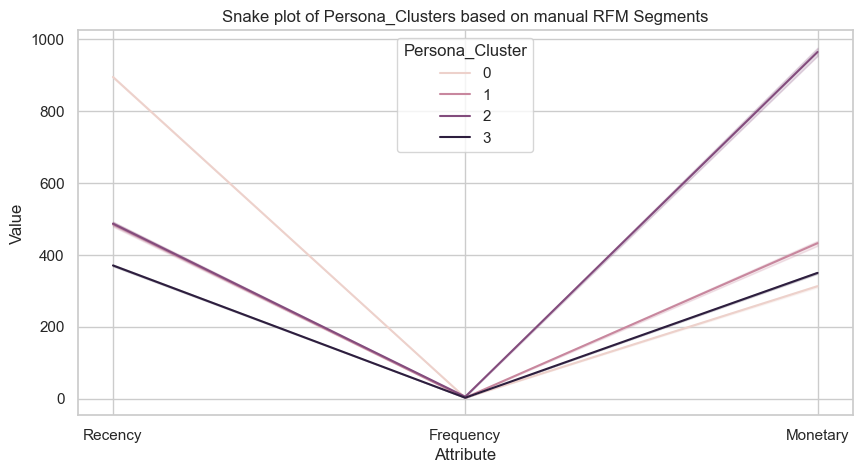

In [120]:
plt.title('Snake plot of Persona_Clusters based on manual RFM Segments')
sns.lineplot(x="Attribute", y="Value", hue='Persona_Cluster', data=model_customer_rfm_persona_melt)


#### Relative Importance Heat Map of Persona Clusters based on manual RFM Segments

In [121]:
cluster_avg3 = snake_segment_persona.groupby(['Persona_Cluster']).mean()
population_avg3 = rfm.mean()
relative_imp3 = cluster_avg3/population_avg3 - 1
relative_imp3 = relative_imp3.round(2)
print(relative_imp3[['Recency','Frequency', 'Monetary']])

                 Recency  Frequency  Monetary
Persona_Cluster                              
0                   0.70      -0.20     -0.35
1                  -0.08      -0.15     -0.10
2                  -0.08       0.73      1.01
3                  -0.30      -0.20     -0.27


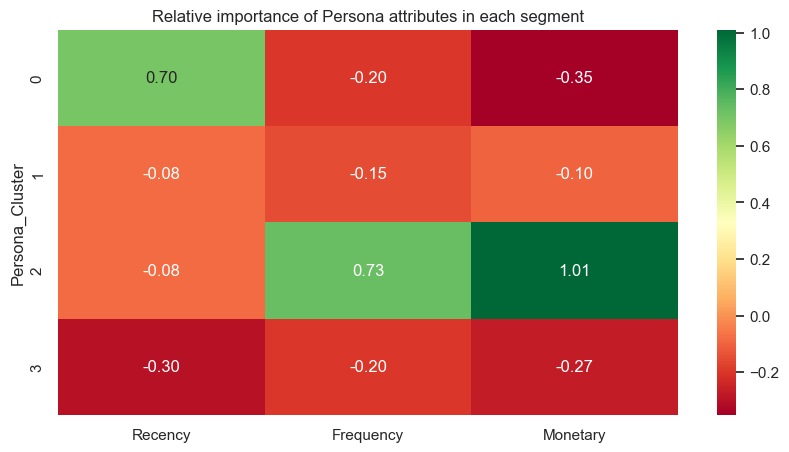

In [122]:
plt.figure(figsize=(10,5))
plt.title('Relative importance of Persona attributes in each segment')
sns.heatmap(data=relative_imp3[['Recency','Frequency', 'Monetary']], annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Insights:

* Persona 3 has the most impactful positive attribute of "Monetary" and second most impactful of "Frequency"
* Persona 0 and 2 have very weak associations with their attributes. 
* Persona 1 has very weak negative impact by Frequncy and Monetary. 

#### Snake Plot for RFM Cluster Set

In [123]:
snake_cluster_persona = pd.merge(model_hotel_customer_rfm_cluster, FM_cluster_kmeans3['Persona_Cluster'], left_index=True, right_index=True)

In [124]:
snake_cluster_persona = pd.merge(CustomerID, snake_cluster_persona, left_index=True, right_index=True)

In [125]:
snake_cluster_persona.head()

ID   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  OtherRevenue  \
0   1  51.0                150               45           371.0         105.3   
1   2   0.0               1095               61           280.0          53.0   
2   4  60.0               1095               93           240.0          60.0   
3   6  54.0               1095               58           230.0          24.0   
4   8  32.0               1095               38           535.0          94.0   

   BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  PersonsNights  ...  \
0                 1                 0                  3              8  ...   
1                 0                 0                  1             10  ...   
2                 0                 0                  1             10  ...   
3                 0                 0                  1              4  ...   
4                 0                 0                  1             10  ...   

   CTRY_ITA  CTRY_NLD  CTRY_Other  CTRY_PRT  CTRY_SWE  CTRY_USA  FM_Clus_Low  \
0         0         0           0         1         0         0            1   
1         0         0           0         1         0         0            1   
2         0         0           0         0         0         0            1   
3         0         0           1         0         0         0            1   
4         0         0           0         0         0         0            1   

   FM_Clus_Mid  FM_Clus_Top  Persona_Cluster  
0            0            0                3  
1            0            0                2  
2            0            0                2  
3            0            0                2  
4            0            0                2  

[5 rows x 58 columns]

In [126]:
model_customer_rfm_cluster_persona_melt = pd.melt(snake_cluster_persona.reset_index(),                     
    id_vars=['ID', 'Persona_Cluster'],                    
    value_vars=['Recency', 'Frequency', 'Monetary'],                     
    var_name='Attribute',                     
    value_name='Value')

<AxesSubplot:title={'center':'Snake plot of Persona_Clusters based on KMeans RFM Clusters'}, xlabel='Attribute', ylabel='Value'>

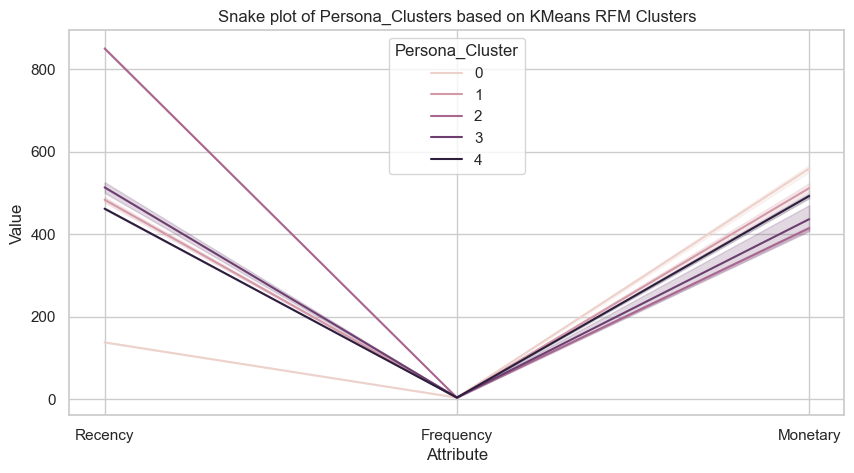

In [127]:
plt.title('Snake plot of Persona_Clusters based on KMeans RFM Clusters')
sns.lineplot(x="Attribute", y="Value", hue='Persona_Cluster', data=model_customer_rfm_cluster_persona_melt)

Persona 0 out performs in Monetary value with both clustering methods.

#### Relative Importance Heat Map of Persona Clusters based on KMeans RFM Clusters

In [128]:
cluster_avg4 = snake_cluster_persona.groupby(['Persona_Cluster']).mean()
population_avg4 = rfm.mean()
relative_imp4 = cluster_avg4/population_avg4 - 1
relative_imp4 = relative_imp4.round(5)
print(relative_imp4[['Recency','Frequency', 'Monetary']])

                 Recency  Frequency  Monetary
Persona_Cluster                              
0               -0.73958    0.02288   0.16208
1               -0.08252   -0.08066   0.06364
2                0.61466   -0.00908  -0.13872
3               -0.02543    0.09289  -0.09312
4               -0.12353    0.01798   0.02373


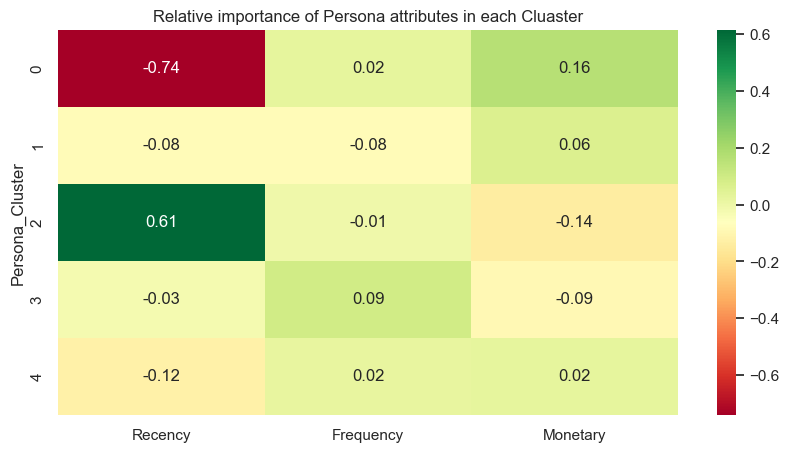

In [129]:
plt.figure(figsize=(10,5))
plt.title('Relative importance of Persona attributes in each Cluaster')
sns.heatmap(data=relative_imp4[['Recency','Frequency', 'Monetary']], annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Insights:

* The most important attribute is Recency here, only impacting the Persona2. 
* Recency has a slight negative impact on Persona0 

## Split the Data into Train and Test sets.

In the spirit of developing a baseline model as simplistic as possible, let's use the dataframe with the RFM quantile segments normalized but no segment label. There are categorical variables are not encoded. 

Convert Attition label to dype int

In [130]:
model_hotel_customer_rfm_norm['Attrition'] = model_hotel_customer_rfm_norm['Attrition'].astype(int)
model_hotel_customer_rfm_norm.Attrition

0        0
1        1
2        1
3        1
4        1
        ..
63665    0
63666    0
63667    0
63668    0
63669    0
Name: Attrition, Length: 63670, dtype: int32

In [131]:
model_hotel_customer_rfm_norm.head()

Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  OtherRevenue  \
0  0.334595          -1.243485        -0.459671       -0.055740      0.133990   
1 -2.554614           1.875127        -0.284167       -0.294030     -0.289058   
2  0.844455           1.875127         0.066842       -0.398773     -0.232436   
3  0.504548           1.875127        -0.317074       -0.424959     -0.523634   
4 -0.741777           1.875127        -0.536454        0.373707      0.042586   

   BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  PersonsNights  \
0         13.109060         -0.024591           3.190277       0.440735   
1         -0.034474         -0.024591          -0.070469       0.905566   
2         -0.034474         -0.024591          -0.070469       0.905566   
3         -0.034474         -0.024591          -0.070469      -0.488927   
4         -0.034474         -0.024591          -0.070469       0.905566   

   DaysSinceFirstStay  ...  CTRY_GBR  CTRY_ITA  CTRY_NLD  CTRY_Other  \
0            1.795864  ... -0.339121 -0.204716 -0.182901   -0.440174   
1            1.881673  ... -0.339121 -0.204716 -0.182901   -0.440174   
2            1.881673  ... -0.339121 -0.204716 -0.182901   -0.440174   
3            1.871772  ... -0.339121 -0.204716 -0.182901    2.271831   
4            1.881673  ... -0.339121 -0.204716 -0.182901   -0.440174   

   CTRY_PRT  CTRY_SWE  CTRY_USA  FM_Seg_Low  FM_Seg_Middle  FM_Seg_Top  
0  2.377329 -0.120213 -0.199326    1.097700      -0.683139   -0.543891  
1  2.377329 -0.120213 -0.199326    1.097700      -0.683139   -0.543891  
2 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   -0.543891  
3 -0.420640 -0.120213 -0.199326    1.097700      -0.683139   -0.543891  
4 -0.420640 -0.120213 -0.199326   -0.910996      -0.683139    1.838603  

[5 rows x 58 columns]

Separate dependent and independent variables. 

In [132]:
ybase = model_hotel_customer_rfm_norm['Attrition']
Xbase = model_hotel_customer_rfm_norm.drop('Attrition', axis = 1)


#X = X.drop('Unnamed: 32', axis = 1)
#X = X.drop('id', axis = 1)

In [133]:
Xbase_train, Xbase_test, ybase_train, ybase_test = train_test_split(
            Xbase, ybase, test_size = 0.3, random_state = 111)

In [134]:
len(Xbase_train)


44569

In [135]:
len(ybase_train)

44569

In [136]:
len(Xbase_test)

19101

In [137]:
len(ybase_test)

19101

## Baseline Dummy Classifier

Cross Validation Score: 0.50122


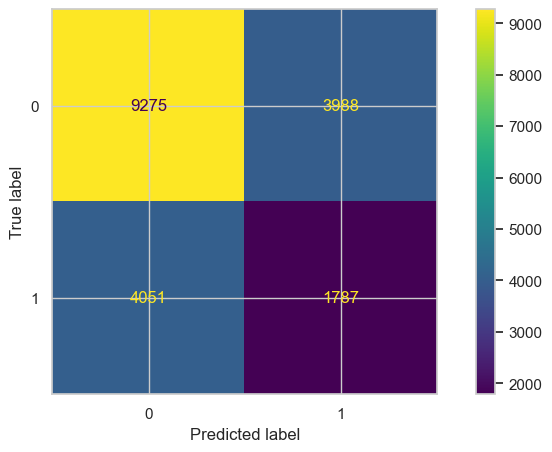

In [138]:
dummy = DummyClassifier(strategy= 'stratified', random_state=42) 

#establishing random_state for reproducibility
dummy.fit(Xbase_train, ybase_train)
ybase_pred = dummy.predict(Xbase_test)

#cross validation score
scores = cross_val_score(dummy, Xbase_train, ybase_train, cv=10, scoring='roc_auc')
print(f'Cross Validation Score: {scores.mean():.5f}')


cm = confusion_matrix(ybase_test, ybase_pred, labels = dummy.classes_ )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy.classes_)
disp.plot()
plt.show()

In [139]:
ybase_train.value_counts(normalize=True)

0    0.69481
1    0.30519
Name: Attrition, dtype: float64

In [140]:
print(classification_report(ybase_test, ybase_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70     13263
           1       0.31      0.31      0.31      5838

    accuracy                           0.58     19101
   macro avg       0.50      0.50      0.50     19101
weighted avg       0.58      0.58      0.58     19101



citation: https://towardsdatascience.com/stop-using-smote-to-treat-class-imbalance-take-this-intuitive-approach-instead-9cb822b8dc45#:~:text=There%20are%20many%20methods%20to,SMOTE%20being%20the%20most%20popular.

### AUC-ROC Score

#### True Positives against False Positives

In [141]:
auc_score1 = roc_auc_score(ybase_test, ybase_pred)
#auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score1)

0.5027059297403258


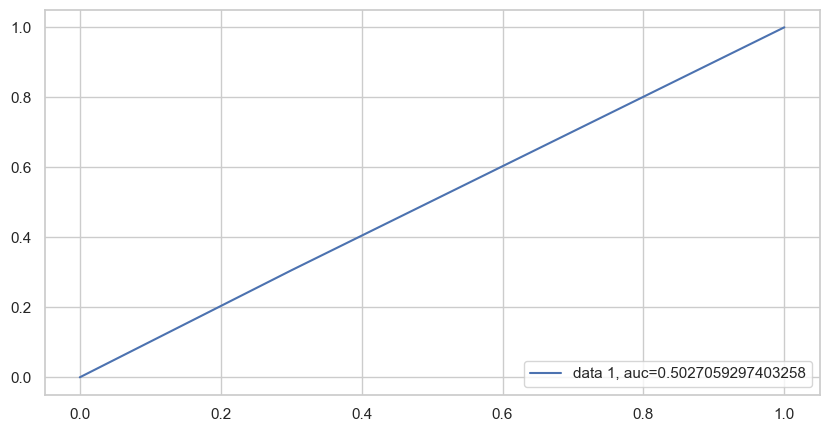

In [142]:
y_pred_proba = dummy.predict_proba(Xbase_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(ybase_test,  y_pred_proba)
auc = metrics.roc_auc_score(ybase_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Citation https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

In [143]:
fpr1, tpr1, thresh1 = roc_curve(ybase_test, ybase_pred, pos_label=1)
random_probs = [0 for i in range(len(ybase_test))]
p_fpr, p_tpr, _ = roc_curve(ybase_test, random_probs, pos_label=1)

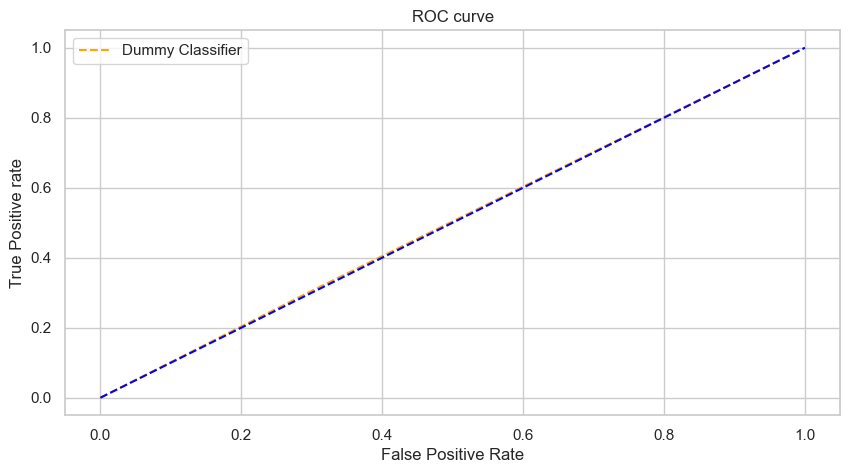

In [144]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Dummy Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

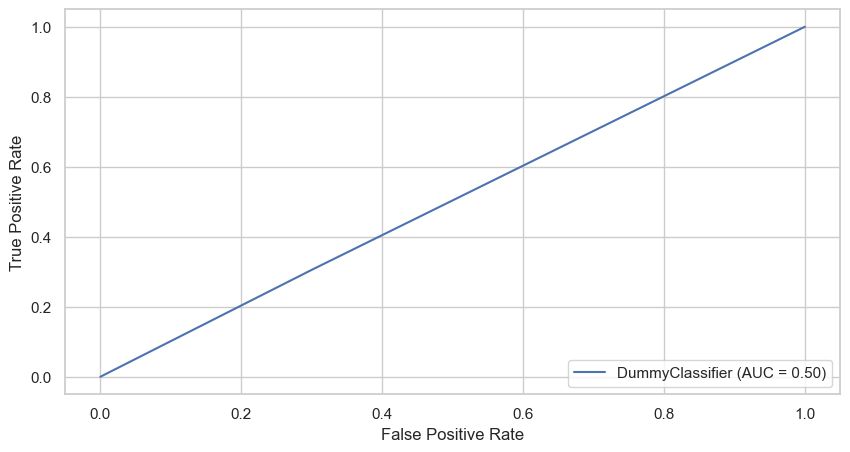

In [145]:
metrics.plot_roc_curve(dummy, Xbase_test, ybase_test) 
plt.show()

#### Create flat excel files with Persona Clusters integrated in to original features for Tableau

Add Persona Cluster to Quantile RFM Segments

In [146]:
hotel_customer_rfm.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   4         FRA  60.0               1095               93           240.0   
3   6         JPN  54.0               1095               58           230.0   
4   8         FRA  32.0               1095               38           535.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2          60.0                 0                 0                  1  ...   
3          24.0                 0                 0                  1  ...   
4          94.0                 0                 0                  1  ...   

   TotalRevenue  Attrition  Recency  Frequency Monetary  M  F  RFM_Score  \
0         476.3      False      151          5    476.3  2  3        5.0   
1         333.0       True     1100          5    333.0  2  3        5.0   
2         300.0       True     1100          5    300.0  2  3        5.0   
3         254.0       True     1097          2    254.0  1  1        2.0   
4         629.0       True     1100          5    629.0  3  3        6.0   

   FM_Score  FM_Segment  
0       5.0         Low  
1       5.0         Low  
2       5.0         Low  
3       2.0         Low  
4       6.0         Top  

[5 rows x 40 columns]

In [147]:
Hotel_Customer_Quan_RFM_Persona_Clusters = pd.merge(hotel_customer_rfm, RFM_segment_kmeans3['Persona_Cluster'], left_index=True, right_index=True)

file_name = 'Hotel_Customer_Quan_RFM_Persona_Clusters.xlsx' 

Hotel_Customer_Quan_RFM_Persona_Clusters.to_excel('Hotel_Customer_Qun_RFM_Persona_Cluster.xlsx')

In [148]:
Hotel_Customer_Quan_RFM_Persona_Clusters.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   4         FRA  60.0               1095               93           240.0   
3   6         JPN  54.0               1095               58           230.0   
4   8         FRA  32.0               1095               38           535.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2          60.0                 0                 0                  1  ...   
3          24.0                 0                 0                  1  ...   
4          94.0                 0                 0                  1  ...   

   Attrition  Recency  Frequency  Monetary  M  F  RFM_Score  FM_Score  \
0      False      151          5     476.3  2  3        5.0       5.0   
1       True     1100          5     333.0  2  3        5.0       5.0   
2       True     1100          5     300.0  2  3        5.0       5.0   
3       True     1097          2     254.0  1  1        2.0       2.0   
4       True     1100          5     629.0  3  3        6.0       6.0   

   FM_Segment  Persona_Cluster  
0         Low                3  
1         Low                0  
2         Low                0  
3         Low                0  
4         Top                2  

[5 rows x 41 columns]

In [149]:
Hotel_Customer_Quan_RFM_Persona_Clusters

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  \
0          1         PRT  51.0                150               45   
1          2         PRT   0.0               1095               61   
2          4         FRA  60.0               1095               93   
3          6         JPN  54.0               1095               58   
4          8         FRA  32.0               1095               38   
...      ...         ...   ...                ...              ...   
63665  83581         DEU  48.0                  0               20   
63666  83583         FRA  49.0                  0               91   
63667  83585         ITA  52.0                  0              116   
63668  83587         IRL  47.0                  0              109   
63669  83589         IRL  85.0                  0              109   

       LodgingRevenue  OtherRevenue  BookingsCanceled  BookingsNoShowed  \
0               371.0         105.3                 1                 0   
1               280.0          53.0                 0                 0   
2               240.0          60.0                 0                 0   
3               230.0          24.0                 0                 0   
4               535.0          94.0                 0                 0   
...               ...           ...               ...               ...   
63665           176.0         147.0                 0                 0   
63666           143.0           2.0                 0                 0   
63667           336.9         105.5                 0                 0   
63668           327.1         277.5                 0                 0   
63669           981.3           9.0                 0                 0   

       BookingsCheckedIn  ...  Attrition  Recency  Frequency  Monetary  M  F  \
0                      3  ...      False      151          5     476.3  2  3   
1                      1  ...       True     1100          5     333.0  2  3   
2                      1  ...       True     1100          5     300.0  2  3   
3                      1  ...       True     1097          2     254.0  1  1   
4                      1  ...       True     1100          5     629.0  3  3   
...                  ...  ...        ...      ...        ...       ... .. ..   
63665                  1  ...      False        2          2     323.0  2  1   
63666                  1  ...      False        1          1     145.0  1  1   
63667                  1  ...      False        4          4     442.4  2  3   
63668                  1  ...      False        3          3     604.6  3  2   
63669                  1  ...      False        3          3     990.3  3  2   

       RFM_Score  FM_Score  FM_Segment  Persona_Cluster  
0            5.0       5.0         Low                3  
1            5.0       5.0         Low                0  
2            5.0       5.0         Low                0  
3            2.0       2.0         Low                0  
4            6.0       6.0         Top                2  
...          ...       ...         ...              ...  
63665        3.0       3.0      Middle                3  
63666        2.0       2.0         Low                3  
63667        5.0       5.0         Low                3  
63668        5.0       5.0         Low                3  
63669        5.0       5.0         Low                3  

[63670 rows x 41 columns]

Add Persona Cluster to KMeans RFM Clusters

In [158]:
hotel_customer_rfm_clustered.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   4         FRA  60.0               1095               93           240.0   
3   6         JPN  54.0               1095               58           230.0   
4   8         FRA  32.0               1095               38           535.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2          60.0                 0                 0                  1  ...   
3          24.0                 0                 0                  1  ...   
4          94.0                 0                 0                  1  ...   

   SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom  Country  \
0                   0                     0            0      PRT   
1                   0                     0            0      PRT   
2                   0                     0            0      FRA   
3                   0                     0            0    Other   
4                   0                     0            0      FRA   

  TotalRevenue Attrition  Recency  Frequency  Monetary  FM_Cluster  
0        476.3     False      151          5     476.3         Low  
1        333.0      True     1100          5     333.0         Low  
2        300.0      True     1100          5     300.0         Low  
3        254.0      True     1097          2     254.0         Low  
4        629.0      True     1100          5     629.0         Low  

[5 rows x 36 columns]

In [159]:
Hotel_Customer_KMeans_RFM_Persona_Clusters = pd.merge(hotel_customer_rfm_clustered, FM_cluster_kmeans3['Persona_Cluster'], left_index=True, right_index=True)


file_name = 'Hotel_Customer_KMeans_RFM_Persona_Clusters.xlsx' 

Hotel_Customer_KMeans_RFM_Persona_Clusters.to_excel('Hotel_Customer_KMeans_RFM_Persona_Cluster.xlsx')


In [160]:
Hotel_Customer_KMeans_RFM_Persona_Clusters.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   4         FRA  60.0               1095               93           240.0   
3   6         JPN  54.0               1095               58           230.0   
4   8         FRA  32.0               1095               38           535.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2          60.0                 0                 0                  1  ...   
3          24.0                 0                 0                  1  ...   
4          94.0                 0                 0                  1  ...   

   SRNoAlcoholInMiniBar  SRQuietRoom  Country  TotalRevenue Attrition Recency  \
0                     0            0      PRT         476.3     False     151   
1                     0            0      PRT         333.0      True    1100   
2                     0            0      FRA         300.0      True    1100   
3                     0            0    Other         254.0      True    1097   
4                     0            0      FRA         629.0      True    1100   

   Frequency  Monetary  FM_Cluster  Persona_Cluster  
0          5     476.3         Low                3  
1          5     333.0         Low                2  
2          5     300.0         Low                2  
3          2     254.0         Low                2  
4          5     629.0         Low                2  

[5 rows x 37 columns]

## Data Story

### Visit this data story analysis on [Tableau Public](https://public.tableau.com/app/profile/lnrobertson/viz/Hotel_Customer_Segmentation/Hotel_Customer_Segmentation?publish=yes)

* Cluster analysis visualizations
* Final analysis visualizations
* Data Flow Diagrams 
* Use and user cases
* Models and Evaluations
* Key Metrics Dashboard